<a href="https://colab.research.google.com/github/vaas-umputer/uncertainty-aware-workflow-scheduler-edge-cloud/blob/main/external_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torch_geometric stable-baselines3 gym numpy shimmy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'


In [ ]:
import os
import random
import numpy as np
import torch
from torch.backends import cudnn
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.use_deterministic_algorithms(True)

seed_everything()

In [ ]:
import json
import networkx as nx
from rich.console import Console
from rich.table import Table

def print_dag_features(dag_files=["balanced_cybershake_dag.json", "balanced_montage_dag.json"]):
    console = Console()
    feature_keys = [
        "execution_time", "cpu_usage", "memory_usage", "arrival_time",
        "power_usage", "monetary_cost", "energy_cost"
    ]

    for dag_file in dag_files:
            with open(dag_file, "r") as f:
                dag_json = json.load(f)
            dag = nx.node_link_graph(dag_json, edges="links")

            table = Table(title=f"DAG Features - {dag_file}")
            table.add_column("Task ID", justify="center")
            for key in feature_keys:
                table.add_column(key.replace("_", " ").title(), justify="center")
            table.add_column("Total Comm Time (s)", justify="center")

            for node in dag.nodes():
                node_data = dag.nodes[node]
                task_features = [f"{float(node_data.get(key, 1.0 if key == 'execution_time' else 0.0)):.2f}" for key in feature_keys]
                total_comm = sum(dag.edges.get((node, succ), {}).get("T_comm", 0.1) for succ in dag.successors(node))
                table.add_row(str(node), *task_features, f"{total_comm:.2f}")

            console.print(table)


if __name__ == "__main__":
    print_dag_features()


                                    DAG Features - balanced_cybershake_dag.json                                    
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃         ┃ Execution  ┃           ┃   Memory   ┃  Arrival   ┃   Power    ┃  Monetary  ┃             ┃ Total Comm ┃
┃ Task ID ┃    Time    ┃ Cpu Usage ┃   Usage    ┃    Time    ┃   Usage    ┃    Cost    ┃ Energy Cost ┃  Time (s)  ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ ID00237 │    1.00    │   0.56    │    0.01    │    5.48    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00344 │   63.17    │   0.04    │    0.03    │   18.93    │   112.00   │    9.48    │    0.00     │    0.00    │
│ ID00371 │    2.00    │   0.39    │    0.01    │    9.47    │   217.00   │    0.30    │    0.00     │    0.00    │
│ ID00388 │   59.00    │   0.06    │    0.02    │   13.91    │   117.40   │    8.85    │    0.00     │    0.00    │
│ ID00378 │   62.00    │   0.02    │    0.03    │    6.86    │   106.00   │    9.30    │    0.00     │    0.00    │
│ ID00732 │    1.00    │   0.56    │    0.01    │    0.44    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00275 │    1.00    │   0.56    │    0.01    │   18.33    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00366 │   28.67    │   0.91    │    0.01    │    1.18    │   374.03   │    4.30    │    0.00     │    0.18    │
│ ID00079 │   59.00    │   0.06    │    0.02    │    1.38    │   117.40   │    8.85    │    0.00     │    0.00    │
│ ID00495 │   28.67    │   0.91    │    0.01    │    0.60    │   374.03   │    4.30    │    0.00     │    0.00    │
│ ID00557 │   44.00    │   0.94    │    0.01    │   11.73    │   382.00   │    6.60    │    0.00     │    0.01    │
│ ID00345 │    1.00    │   0.56    │    0.01    │   11.04    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00600 │    1.00    │   0.56    │    0.01    │    7.56    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00569 │   44.64    │   0.92    │    0.01    │    2.56    │   375.00   │    6.70    │    0.00     │    0.02    │
│ ID00146 │    1.00    │   0.56    │    0.01    │    1.62    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00832 │   45.89    │   0.89    │    0.01    │    4.94    │   366.00   │    6.88    │    0.00     │    0.00    │
│ ID00880 │   48.67    │   0.99    │    0.01    │    5.89    │   396.00   │    7.30    │    0.00     │    0.00    │
│ ID00618 │    2.00    │   0.39    │    0.01    │   54.13    │   217.00   │    0.30    │    0.00     │    0.00    │
│ ID00006 │    1.00    │   0.56    │    0.01    │   17.37    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00516 │    1.00    │   0.56    │    0.01    │    0.81    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00315 │    1.00    │   0.56    │    0.01    │    4.07    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00892 │   44.00    │   0.94    │    0.01    │    3.81    │   382.00   │    6.60    │    0.00     │    0.00    │
│ ID00050 │    2.00    │   0.39    │    0.01    │   23.65    │   217.00   │    0.30    │    0.00     │    0.00    │
│ ID00989 │    1.00    │   0.56    │    0.01    │    2.10    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00584 │    1.00    │   0.56    │    0.01    │    6.39    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00765 │    1.00    │   0.56    │    0.01    │   16.47    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00327 │    1.00    │   0.56    │    0.01    │   19.26    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00542 │    1.00    │   0.56    │    0.01    │    2.44    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00390 │   30.44    │   0.61    │    0.02    │   28.33    │   283.89   │    4.57    │    0.00     │    0.00    │
│ ID00519 │   20.77    │   0.90    │    0.01    │    5.1

                                     DAG Features - balanced_montage_dag.json                                      
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃         ┃ Execution  ┃           ┃   Memory   ┃  Arrival   ┃   Power    ┃  Monetary  ┃             ┃ Total Comm ┃
┃ Task ID ┃    Time    ┃ Cpu Usage ┃   Usage    ┃    Time    ┃   Usage    ┃    Cost    ┃ Energy Cost ┃  Time (s)  ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ ID00759 │   10.65    │   0.74    │    0.01    │    4.87    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00421 │   10.65    │   0.74    │    0.01    │   10.31    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00482 │   10.65    │   0.74    │    0.01    │    5.22    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00142 │   13.00    │   0.65    │    0.01    │   22.15    │   293.50   │    1.95    │    0.00     │    1.15    │
│ ID00664 │   10.65    │   0.74    │    0.01    │    5.90    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00518 │   10.65    │   0.74    │    0.01    │   12.12    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00822 │   10.65    │   0.74    │    0.01    │    1.77    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00768 │   10.65    │   0.74    │    0.01    │    6.72    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00134 │   13.50    │   0.65    │    0.01    │    7.40    │   293.50   │    2.02    │    0.00     │    0.18    │
│ ID00583 │   10.65    │   0.74    │    0.01    │   11.35    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00149 │   13.50    │   0.65    │    0.01    │    0.42    │   293.50   │    2.02    │    0.00     │    0.47    │
│ ID00106 │   13.50    │   0.65    │    0.01    │    0.10    │   293.50   │    2.02    │    0.00     │    0.59    │
│ ID00089 │   13.50    │   0.65    │    0.01    │   15.83    │   293.50   │    2.02    │    0.00     │    0.34    │
│ ID00271 │   10.65    │   0.74    │    0.01    │    9.20    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00884 │   11.00    │   0.21    │    0.01    │    2.68    │   161.50   │    1.65    │    0.00     │    0.02    │
│ ID00483 │   10.65    │   0.74    │    0.01    │   22.55    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00409 │   10.65    │   0.74    │    0.01    │    4.47    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00077 │   13.50    │   0.65    │    0.01    │    7.96    │   293.50   │    2.02    │    0.00     │    0.26    │
│ ID00975 │   10.65    │   0.74    │    0.01    │    5.12    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00761 │   10.65    │   0.74    │    0.01    │    1.13    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00696 │   10.65    │   0.74    │    0.01    │    6.02    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00349 │   10.65    │   0.74    │    0.01    │    1.22    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00440 │   10.65    │   0.74    │    0.01    │   17.72    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00742 │   10.65    │   0.74    │    0.01    │    6.12    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00130 │   13.50    │   0.65    │    0.01    │   15.47    │   293.50   │    2.02    │    0.00     │    0.56    │
│ ID00263 │   10.65    │   0.74    │    0.01    │    8.98    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00316 │   10.65    │   0.74    │    0.01    │   21.20    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00293 │   10.65    │   0.74    │    0.01    │    1.36    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00548 │   10.65    │   0.74    │    0.01    │    0.21    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00261 │   10.65    │   0.74    │    0.01    │    7.0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class ContrastiveGAT(nn.Module):
    def __init__(self, in_channels=9, hidden_channels=16, embedding_dim=32, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.2, add_self_loops=False)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=0.2, add_self_loops=False)
        self.node_to_embed = nn.Linear(hidden_channels * heads, embedding_dim)
        self.edge_proj = nn.Linear(1, hidden_channels)
        self.graph_fc = nn.Linear(hidden_channels * heads, embedding_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        # Generate task and graph embeddings
        # Inputs: x [num_nodes, 9], edge_index [2, num_edges], edge_attr [num_edges, 1], batch [num_nodes]
        # Outputs: task_embeddings [num_nodes, 32], graph_embedding [num_graphs, 32]

        x = torch.nan_to_num(x, nan=0.0)
        edge_attr = edge_attr
        #if edge_attr is not None else torch.full((edge_index.shape[1], 1), 0.1, device=x.device)
        edge_attr = torch.nan_to_num(edge_attr, nan=0.1)

        edge_attr = self.edge_proj(edge_attr)
        x = F.relu(self.gat1(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.2, training=True)
        x = F.relu(self.gat2(x, edge_index, edge_attr=edge_attr))

        task_embeddings = self.node_to_embed(x)
        graph_embedding = global_mean_pool(x, batch)
        graph_embedding = self.graph_fc(graph_embedding)

        return task_embeddings, graph_embedding

    def contrastive_loss(self, embeddings, edge_index, num_nodes):
        # Contrastive loss for connected task embeddings
        embeddings = torch.nan_to_num(embeddings, nan=0.0)
        if edge_index.shape[1] == 0:
            return torch.tensor(0.0, requires_grad=True)

        pos_pairs = embeddings[edge_index[0]] - embeddings[edge_index[1]]
        pos_loss = (pos_pairs ** 2).sum(dim=1).mean()

        num_neg = min(int(num_nodes * 0.1), 500)
        neg_idx1 = torch.randint(0, num_nodes, (num_neg,))
        neg_idx2 = torch.randint(0, num_nodes, (num_neg,))
        mask = neg_idx1 != neg_idx2
        neg_idx1, neg_idx2 = neg_idx1[mask], neg_idx2[mask]

        if len(neg_idx1) == 0:
            return pos_loss

        neg_pairs = embeddings[neg_idx1] - embeddings[neg_idx2]
        neg_loss = F.relu(1.0 - (neg_pairs ** 2).sum(dim=1)).mean()
        return pos_loss + 0.5 * neg_loss




In [ ]:
import torch
from torch_geometric.data import Data
import json
import networkx as nx
import numpy as np
from rich.console import Console

class GNNTrainer:
    def __init__(self, dag_file, embeddings_file, model_file="gnn_model.pth", max_nodes=1000, embedding_dim=32):
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.model_file = model_file
        self.max_nodes = max_nodes
        self.embedding_dim = embedding_dim
        self.console = Console()
        self.dag = self.load_dag()
        self.model = ContrastiveGAT(embedding_dim=self.embedding_dim)

    def load_dag(self):
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)
        dag = nx.node_link_graph(dag_json, edges="links")
        return dag

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
        self.model.eval()

    def prepare_data(self):
        node_to_idx = {nid: i for i, nid in enumerate(self.dag.nodes)}
        feature_keys = ["execution_time", "cpu_usage", "memory_usage", "arrival_time", "power_usage", "monetary_cost", "energy_cost"]
        x = torch.tensor([
            [float(self.dag.nodes[n].get(k, 0.5)) for k in feature_keys] +
            ([1.0, 0.0] if self.dag.nodes[n].get("machine_type", "cloud") == "edge" else [0.0, 1.0])
            for n in self.dag.nodes
        ], dtype=torch.float)
        x = torch.nan_to_num(x, nan=0.5)
        x = (x - x.mean(dim=0)) / torch.where(x.std(dim=0) > 0, x.std(dim=0), torch.ones_like(x.std(dim=0)))
        #x = (x - x.median(dim=0).values) / (x.quantile(0.75, dim=0) - x.quantile(0.25, dim=0) + 1e-6)
        edge_index = torch.tensor([[node_to_idx[e[0]], node_to_idx[e[1]]] for e in self.dag.edges], dtype=torch.long).t() if self.dag.edges else torch.tensor([[], []], dtype=torch.long)
        edge_attr = torch.tensor([[self.dag.edges[e].get("T_comm", 0.1)] for e in self.dag.edges], dtype=torch.float) if self.dag.edges else torch.tensor([[0.1]], dtype=torch.float)
        edge_attr = torch.nan_to_num(edge_attr, nan=0.1)
        batch = torch.zeros(len(self.dag.nodes), dtype=torch.long)
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)

    def get_mc_embeddings(self, model, data, num_samples=30):
        model.eval()
        task_embed_samples = [
            model(data.x, data.edge_index, data.edge_attr, data.batch)[0].unsqueeze(0)
            for _ in range(num_samples)
        ]
        task_embed_samples = torch.cat(task_embed_samples, dim=0)
        return task_embed_samples.mean(dim=0), task_embed_samples.var(dim=0)

    def compute_metrics(self, embeddings, edge_index, task_ids):
        embeddings = embeddings.detach().cpu().numpy()
        pos_sim = neg_sim = emb_var = 0.0
        if edge_index.shape[1] > 0:
            pos_sim = np.mean([
                np.dot(embeddings[i], embeddings[j]) / (max(np.linalg.norm(embeddings[i]), 1e-8) * max(np.linalg.norm(embeddings[j]), 1e-8))
                for i, j in zip(edge_index[0].numpy(), edge_index[1].numpy())
            ])
        n_samples = min(100, len(task_ids))
        idx1, idx2 = np.random.choice(len(task_ids), (2, n_samples), replace=True)
        mask = idx1 != idx2
        idx1, idx2 = idx1[mask], idx2[mask]
        if len(idx1) > 0:
            neg_sim = np.mean([
                np.dot(embeddings[i], embeddings[j]) / (max(np.linalg.norm(embeddings[i]), 1e-8) * max(np.linalg.norm(embeddings[j]), 1e-8))
                for i, j in zip(idx1, idx2)
            ])
        emb_var = np.var(embeddings, axis=0).mean() if embeddings.size > 0 else 0.0
        return {"pos_sim": pos_sim, "neg_sim": neg_sim, "emb_var": emb_var}

    def save_embeddings(self, data, device):
        self.model.eval()
        data = data.to(device)
        task_mean, task_var = self.get_mc_embeddings(self.model, data)
        task_embeddings_dict = {
            nid: {"mean": mean.tolist(), "uncertainty": var.tolist()}
            for nid, mean, var in zip(self.dag.nodes, task_mean, task_var)
        }
        torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
        self.console.log(f"Saved embeddings to {self.embeddings_file}")

    def train(self, epochs=10):
        self.console.log(f"Training GNN with embedding_dim={self.embedding_dim}...")
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.console.log(f"Using device: {device}")
        self.model.to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001, weight_decay=5e-4) #added weight decay
        data = self.prepare_data().to(device)

        for epoch in range(1, epochs + 1):
            self.model.train()
            optimizer.zero_grad()
            task_embeddings, _ = self.model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = self.model.contrastive_loss(task_embeddings, data.edge_index, len(data.x))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()
            if epoch % 2 == 0:
                metrics = self.compute_metrics(task_embeddings, data.edge_index, list(self.dag.nodes))
                self.console.log(
                    f"Epoch {epoch}/{epochs}: Loss={loss.item():.4f}, "
                    f"Pos Sim={metrics['pos_sim']:.4f}, Neg Sim={metrics['neg_sim']:.4f}, "
                    f"Emb Var={metrics['emb_var']:.4f}"
                )

        self.model.eval()
        task_mean, task_var = self.get_mc_embeddings(self.model, data)
        task_embeddings_dict = {
            nid: {"mean": mean.tolist(), "uncertainty": var.tolist()}
            for nid, mean, var in zip(self.dag.nodes, task_mean, task_var)
        }
        torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
        torch.save(self.model.state_dict(), self.model_file)
        self.console.log(f"Saved embeddings to {self.embeddings_file}")
        self.console.log(f"Saved GNN model to {self.model_file}")
        metrics = self.compute_metrics(task_mean, data.edge_index, list(self.dag.nodes))
        self.console.log(
            f"Final Metrics: Pos Sim={metrics['pos_sim']:.4f}, Neg Sim={metrics['neg_sim']:.4f}, "
            f"Emb Var={metrics['emb_var']:.4f}"
        )

In [ ]:
import torch
import numpy as np
from rich.console import Console

class TaskQueue:
    def __init__(self, dag, embeddings, task_ids, num_servers=5):
        self.dag = dag
        self.task_ids = task_ids
        self.tasks = {
            node: {
                "embedding": embeddings[i] if i < len(embeddings) else np.zeros(embeddings.shape[1]),
                "dependencies": set(dag.predecessors(node)),
                "exec_time": dag.nodes[node].get("execution_time", 1.0),
                "arrival_time": dag.nodes[node].get("arrival_time", 0.0),
                "monetary_cost": dag.nodes[node].get("monetary_cost", 1.0),
                "energy_cost": dag.nodes[node].get("energy_cost", 1.0),
                "placement": None,
                "server": None,
                "history": []
            } for i, node in enumerate(task_ids)
        }
        self.completed = set()
        self.running = {}
        self.server_loads = {"cloud": np.zeros(num_servers), "edge": np.zeros(num_servers)}
        self.edge_battery = np.full(num_servers, 100.0)
        self.network_latency = 0.5
        self.current_time = 0.0
        self.total_cost = 0.0
        self.total_energy = 0.0
        self.console = Console()
        self.cloud_base_power = np.random.uniform(10, 15, num_servers)
        self.edge_base_power = np.random.uniform(2, 5, num_servers)
        self.load_history = {"cloud": [], "edge": []}
        self.placement_log = {}
        self.overload_feedback = {"cloud": False, "edge": False}

    def reset(self):
        self.completed.clear()
        self.running.clear()
        self.server_loads = {"cloud": np.zeros_like(self.server_loads["cloud"]), "edge": np.zeros_like(self.server_loads["edge"])}
        self.edge_battery.fill(100.0)
        self.network_latency = 0.5
        self.current_time = 0.0
        self.total_cost = 0.0
        self.total_energy = 0.0
        self.load_history = {"cloud": [], "edge": []}
        self.placement_log.clear()
        for task in self.tasks.values():
            task["placement"] = None
            task["server"] = None
            task["history"].clear()

    def update_conditions(self):
        self.network_latency = np.random.uniform(0.3, 0.7)
        self.server_loads["cloud"] += np.random.uniform(0, 0.2, len(self.server_loads["cloud"]))
        self.server_loads["edge"] += np.random.uniform(0, 0.1, len(self.server_loads["edge"]))
        self.server_loads["cloud"] = np.clip(self.server_loads["cloud"], 0, 2.0)
        self.server_loads["edge"] = np.clip(self.server_loads["edge"], 0, 1.5)
        self.edge_battery = np.clip(self.edge_battery + 0.5, 0, 100)
        self.load_history["cloud"].append(self.server_loads["cloud"].copy())
        self.load_history["edge"].append(self.server_loads["edge"].copy())
        if len(self.load_history["cloud"]) > 10:
            self.load_history["cloud"].pop(0)
            self.load_history["edge"].pop(0)
        self.overload_feedback["cloud"] = np.any(self.server_loads["cloud"] > 2.0)
        self.overload_feedback["edge"] = np.any(self.server_loads["edge"] > 1.5) or np.any(self.edge_battery < 20)

    def get_ready_tasks(self):
        return [
            tid for tid, t in self.tasks.items()
            if tid not in self.running
            and tid not in self.completed
            and t["arrival_time"] <= self.current_time
            and t["dependencies"].issubset(self.completed)
        ]

    def update_running(self):
        completed = [t for t, info in self.running.items() if self.current_time >= info["expected_end"]]
        for task in completed:
            self.complete_task(task)
        self.edge_battery = np.minimum(self.edge_battery + 0.5, 100.0)
        if self.running and not completed:
            self.current_time += 0.5

    def clear_running(self):
        for task in list(self.running.keys()):
            self.complete_task(task)
        self.running.clear()
        self.current_time = max(self.current_time, 0.0)

    def start_task(self, task_id, placement, server, exec_time):
        if task_id not in self.tasks:
            return
        exec_time = min(exec_time, 10.0)
        base_power = self.cloud_base_power[server] if placement == "cloud" else self.edge_base_power[server]
        load_factor = min(self.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.4)
        energy = (base_power + load_factor * 5) * exec_time
        if placement == "edge":
            self.edge_battery[server] = max(0.0, self.edge_battery[server] - energy)
        self.server_loads[placement][server] += self.tasks[task_id]["exec_time"] / (3.0 if placement == "cloud" else 2.0)
        self.running[task_id] = {
            "placement": placement,
            "server": server,
            "expected_end": self.current_time + exec_time,
            "energy": energy,
            "exec_time": exec_time
        }
        self.placement_log[task_id] = {"placement": placement, "server": server}

    def complete_task(self, task_id):
        if task_id not in self.running:
            return
        task_info = self.running[task_id]
        exec_time = task_info["exec_time"]
        placement = task_info["placement"]
        server = task_info["server"]
        self.server_loads[placement][server] = max(0, self.server_loads[placement][server] - exec_time * 0.1)
        base_power = self.cloud_base_power[server] if placement == "cloud" else self.edge_base_power[server]
        load_factor = min(self.server_loads[placement][server] / (2.0 if placement == "cloud" else 1.5), 0.4)
        energy = (base_power + load_factor * 5) * exec_time
        cost = exec_time * (0.10 if placement == "cloud" else 0.05)
        sla_deadline = self.tasks[task_id]["exec_time"] * 1.5
        sla_met = 1 if exec_time <= sla_deadline else 0
        self.total_energy += energy
        self.total_cost += cost
        self.tasks[task_id]["history"].append({
            "exec_time": exec_time,
            "energy": energy,
            "cost": cost,
            "sla": sla_met,
            "placement": placement,
            "server": server,
            "timestamp": self.current_time
        })
        self.completed.add(task_id)
        del self.running[task_id]

    def get_historical_state(self, task_id):
        history = self.tasks[task_id]["history"]
        return np.array([1.0, 0.8, 0.5, 0.0, 1.0]) if not history else np.array([
            history[-1]["exec_time"],
            history[-1]["energy"],
            history[-1]["cost"],
            history[-1]["sla"],
            1 if history[-1]["placement"] == "cloud" else 0
        ])

    def predict_load(self, placement):
        history = self.load_history[placement]
        return np.mean(history, axis=0) if history else self.server_loads[placement]

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class Tier1SchedulerEnv(gym.Env):
    def __init__(self, task_queue, embeddings, task_ids, embeddings_var=None):
        super().__init__()
        self.task_queue = task_queue
        self.embeddings = embeddings
        self.task_ids = task_ids
        self.embeddings_var = embeddings_var
        self.action_space = spaces.MultiBinary(5)
        emb_dim = embeddings.shape[1]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=((emb_dim + 19 + 5) * 5,),
            dtype=np.float32
        )
        self.max_exec_time = 10.0

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.task_queue.reset()
        return self._get_obs(), {"reset": True}

    def _get_obs(self):
        ready_tasks = self.task_queue.get_ready_tasks()[:5]
        emb_dim = self.embeddings.shape[1]
        task_obs_dim = emb_dim + 19 + 5
        obs = []
        for i in range(5):
            if i < len(ready_tasks):
                tid = ready_tasks[i]
                idx = self.task_ids.index(tid)
                emb = np.nan_to_num(self.embeddings[idx], nan=0.0)
                system_state = np.concatenate([
                    [self.task_queue.current_time, len(self.task_queue.running), len(ready_tasks), self.task_queue.network_latency],
                    self.task_queue.server_loads["cloud"],
                    self.task_queue.server_loads["edge"],
                    self.task_queue.edge_battery
                ])
                historical_state = self.task_queue.get_historical_state(tid)
                obs.append(np.concatenate([emb, system_state, historical_state]))
            else:
                obs.append(np.zeros(task_obs_dim))
        return np.concatenate(obs).astype(np.float32)

    """def _calculate_reward(self, tid, placement, exec_time, base_time, energy, cost):
        sla_met = 1 if exec_time <= base_time * 1.5 else 0
        edge_bonus = 1.5 if placement == "edge" and np.mean(self.task_queue.edge_battery) > 50 else 0.0
        reward = 50.0 * sla_met - 0.1 * (exec_time / 5.0) - 0.02 * (energy / 5.0) - 0.05 * (cost / 10.0) + edge_bonus

        idx = self.task_ids.index(tid)
        if self.embeddings_var is not None:
            uncertainty = np.mean(self.embeddings_var[idx])
            reward -= 0.2 * uncertainty
            if uncertainty < 0.05 and placement == "cloud":
                reward -= 0.5

        if self.task_queue.overload_feedback[placement]:
            reward -= 0.5

        return reward"""

    def _calculate_reward(self, tid, placement, exec_time, base_time, energy, cost):
        # More balanced reward components
        time_factor = min(exec_time / base_time, 3.0)
        sla_met = 1 if time_factor <= 1.5 else 0

        # Dynamic edge bonus based on battery level
        battery_level = np.mean(self.task_queue.edge_battery)
        edge_bonus = (2.0 if placement == "edge" and battery_level > 60 else
                      1.0 if placement == "edge" and battery_level > 30 else
                      0.0)

        # Uncertainty penalty scaled differently
        uncertainty_penalty = 0.0
        if self.embeddings_var is not None:
            idx = self.task_ids.index(tid)
            uncertainty = np.mean(self.embeddings_var[idx])
            uncertainty_penalty = 0.5 * (uncertainty ** 0.5)  # Less harsh penalty

        reward = (60.0 * sla_met -
                10.0 * time_factor -
                0.05 * energy -
                0.1 * cost +
                edge_bonus -
                uncertainty_penalty)

        if self.task_queue.overload_feedback[placement]:
            reward -= 1.0  # Reduced penalty

        return reward

    def step(self, action):
        self.task_queue.update_running()
        ready_tasks = self.task_queue.get_ready_tasks()[:5]
        if not ready_tasks:
            self.task_queue.current_time += 0.5
            return self._get_obs(), 0, False, False, {"placements": {}}

        self.task_queue.update_conditions()
        placements = {}
        total_reward = 0
        cloud_count = 0

        for i, tid in enumerate(ready_tasks):
            placement = "cloud" if action[i] == 0 else "edge"
            if placement == "cloud":
                cloud_count += 1

            base_time = self.task_queue.tasks[tid]["exec_time"]
            exec_time = base_time

            if placement == "edge" and base_time > 5.0 and np.mean(self.task_queue.edge_battery) < 20:
                exec_time = base_time / np.ceil(base_time / 2.0)

            load_factor = min(np.mean(self.task_queue.server_loads[placement]) / (2.0 if placement == "cloud" else 1.5), 0.3)
            exec_time *= 1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5)
            exec_time = min(exec_time, 5.0)

            base_power = np.mean(self.task_queue.cloud_base_power if placement == "cloud" else self.task_queue.edge_base_power)
            energy = (base_power + load_factor * 5) * exec_time
            cost = exec_time * (0.10 if placement == "cloud" else 0.05)

            reward = self._calculate_reward(tid, placement, exec_time, base_time, energy, cost)
            total_reward += reward
            placements[tid] = {"placement": placement, "exec_time": exec_time, "energy": energy, "cost": cost}

        cloud_ratio = cloud_count / len(ready_tasks) if ready_tasks else 0.0
        if cloud_ratio < 0.3 or cloud_ratio > 0.7:
            total_reward -= 3.0

        terminated = len(self.task_queue.completed) == len(self.task_ids)
        return self._get_obs(), total_reward, terminated, False, {"placements": placements, "cloud_ratio": cloud_ratio}

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class Tier2SchedulerEnv(gym.Env):
    def __init__(self, task_queue, embeddings, task_ids):
        super().__init__()
        self.task_queue = task_queue
        self.embeddings = embeddings
        self.task_ids = task_ids
        self.action_space = spaces.MultiDiscrete([5] * 5)
        emb_dim = embeddings.shape[1]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=((emb_dim + 19 + 5) * 5,),
            dtype=np.float32
        )
        self.current_tasks = []
        self.placements = {}
        self.max_exec_time = 10.0

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.current_tasks.clear()
        self.placements.clear()
        return self._get_obs(), {"reset": True}

    def _get_obs(self):
        task_obs_dim = self.embeddings.shape[1] + 19 + 5
        obs = []
        for i in range(5):
            if i < len(self.current_tasks):
                tid = self.current_tasks[i]
                idx = self.task_ids.index(tid) if tid in self.task_ids else -1
                emb = np.nan_to_num(self.embeddings[idx], nan=0.0) if idx >= 0 else np.zeros(self.embeddings.shape[1])
                system_state = np.concatenate([
                    [self.task_queue.current_time, len(self.task_queue.running), len(self.task_queue.get_ready_tasks()), self.task_queue.network_latency],
                    self.task_queue.server_loads["cloud"],
                    self.task_queue.server_loads["edge"],
                    self.task_queue.edge_battery if self.placements.get(tid) == "edge" else np.zeros(5)
                ])
                historical_state = self.task_queue.get_historical_state(tid) if idx >= 0 else np.zeros(5)
                obs.append(np.concatenate([emb, system_state, historical_state]))
            else:
                obs.append(np.zeros(task_obs_dim))
        return np.concatenate(obs).astype(np.float32)

    def step(self, action):
        total_reward = 0
        info_dict = {}
        edge_placements = sum(1 for tid in self.current_tasks if self.placements.get(tid) == "edge")
        cloud_placements = len(self.current_tasks) - edge_placements
        cloud_ratio = cloud_placements / len(self.current_tasks) if self.current_tasks else 0.0

        for i, tid in enumerate(self.current_tasks[:5]):
            server = int(action[i]) % 5
            placement = self.placements.get(tid, "cloud")
            base_time = min(self.task_queue.tasks[tid]["exec_time"], 5.0)
            exec_time = base_time
            if base_time > 3.0 and self.task_queue.server_loads["cloud"][server] < 1.5:
                placement = "cloud"
            if placement == "edge" and base_time > 5.0 and self.task_queue.edge_battery[server] < 20:
                exec_time = base_time / np.ceil(base_time / 2.0)
            predicted_load = self.task_queue.predict_load(placement)
            if predicted_load[server] >= (3.0 if placement == "cloud" else 2.0):
                total_reward -= 1
                continue
            load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)
            exec_time *= (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
            exec_time = min(exec_time, 5.0)
            self.task_queue.start_task(tid, placement, server, exec_time)
            sla_met = 1 if exec_time <= base_time * 1.5 else 0
            base_power = self.task_queue.cloud_base_power[server] if placement == "cloud" else self.task_queue.edge_base_power[server]
            energy = (base_power + load_factor * 5) * exec_time
            cost = exec_time * (0.10 if placement == "cloud" else 0.05)
            load_balance = -0.5 * np.std(self.task_queue.server_loads[placement])
            if cloud_ratio < 0.4:
                load_balance -= 0.7 * np.std(self.task_queue.server_loads["edge"])
                total_reward -= 5.0
            reward = 40.0 * sla_met - 0.05 * (exec_time / 5.0) - 0.02 * (energy / 5.0) - 0.03 * (cost / 10.0) + load_balance
            total_reward += reward
            info_dict[tid] = {"task": tid, "exec_time": exec_time, "energy": energy, "cost": cost, "placement": placement}

        self.task_queue.update_running()
        terminated = len(self.task_queue.completed) == len(self.task_ids)
        self.current_tasks.clear()
        self.placements.clear()
        return self._get_obs(), total_reward, terminated, False, {"tasks": info_dict, "cloud_ratio": cloud_ratio}

In [ ]:
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from rich.console import Console
import json
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from rich.table import Table
import os

class WorkflowScheduler:
    def __init__(self, dag_file, embeddings_file, validation_dag_file="balanced_montage_dag.json", max_nodes=1000):
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.validation_dag_file = validation_dag_file
        self.max_nodes = max_nodes
        self.console = Console()
        self.dag, self.embeddings, self.task_ids, self.embeddings_var = self.load_dag_and_embeddings(
            self.dag_file, self.embeddings_file
        )
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)
        self.tier1_env = Tier1SchedulerEnv(self.task_queue, self.embeddings, self.task_ids, self.embeddings_var)
        self.tier2_env = Tier2SchedulerEnv(self.task_queue, self.embeddings, self.task_ids)
        self.tier1_model = None
        self.tier2_model = None
        self.metrics = {"hrl": None, "cloud": None, "edge": None}

    def load_dag_and_embeddings(self, dag_file, embeddings_file, is_validation=False):
        with open(dag_file, "r") as f:
            dag = nx.node_link_graph(json.load(f), edges="links")

        if not os.path.exists(embeddings_file):
            trainer = GNNTrainer(dag_file, embeddings_file, embedding_dim=32)
            trainer.dag = dag
            if is_validation:
                trainer.load_model("gnn_model.pth")
                data = trainer.prepare_data()
                device = "cuda" if torch.cuda.is_available() else "cpu"
                trainer.save_embeddings(data, device)
            else:
                task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}
                torch.save({"task_embeddings": task_embeddings_dict}, embeddings_file)

        embeddings_data = torch.load(embeddings_file, map_location=torch.device('cpu'))
        task_embeddings_dict = embeddings_data["task_embeddings"]
        task_ids = list(dag.nodes())
        task_embeddings = np.array([task_embeddings_dict[tid]["mean"] for tid in task_ids])
        task_embeddings_var = np.array([task_embeddings_dict[tid]["uncertainty"] for tid in task_ids])
        embeddings_var = task_embeddings_var if np.any(task_embeddings_var) else None
        return dag, task_embeddings, task_ids, embeddings_var

    def train_tier1(self, timesteps=20000):
        self.console.log("Training Tier 1...")
        self.tier1_env.task_queue.active_phase = True
        self.tier1_model = PPO("MlpPolicy", DummyVecEnv([lambda: self.tier1_env]), verbose=0, n_steps=256, ent_coef=0.01, learning_rate=0.001)
        self.tier1_model.learn(total_timesteps=timesteps)
        self.tier1_model.save("tier1_scheduler_new")
        self.tier1_env.task_queue.clear_running()
        self.tier1_env.task_queue.active_phase = False
        self.console.log("Tier 1 training complete")

    def _advance_time_if_idle(self):
        if not self.tier1_env.task_queue.get_ready_tasks() and not self.tier1_env.task_queue.running:
            future_arrivals = [
                t["arrival_time"] for t in self.tier1_env.task_queue.tasks.values()
                if t["arrival_time"] > self.tier1_env.task_queue.current_time and t["dependencies"].issubset(self.tier1_env.task_queue.completed)
            ]
            if future_arrivals:
                self.tier1_env.task_queue.current_time = self.tier2_env.task_queue.current_time = min(future_arrivals)
                return True
            return False
        return True

    def train_tier2(self, timesteps=20000):
        self.console.log("Training Tier 2...")
        self.tier1_env.reset()
        self.tier2_env.reset()
        self.tier1_env.task_queue.clear_running()
        self.tier2_env.task_queue.clear_running()
        self.tier1_env.task_queue.active_phase = True
        self.tier2_env.task_queue.active_phase = True
        self.tier1_model = PPO.load("tier1_scheduler_new")
        #self.tier2_model = PPO("MlpPolicy", DummyVecEnv([lambda: self.tier2_env]), verbose=0, n_steps=256, ent_coef=0.05, learning_rate=0.001)
        self.tier2_model = PPO(
        "MlpPolicy",
        DummyVecEnv([lambda: self.tier2_env]),
        verbose=0,
        n_steps=512,  # Increased batch size
        ent_coef=0.02,  # Lower entropy coefficient
        learning_rate=0.0003,  # Smaller learning rate
        gamma=0.99,  # Higher discount factor
        gae_lambda=0.95,
        clip_range=0.2
    )
        # Initial learning to bootstrap the policy
        self.tier2_model.learn(total_timesteps=128, reset_num_timesteps=False)
        obs = self.tier1_env.reset()[0]
        for _ in range(timesteps // 128):
            if not self._advance_time_if_idle():
                break
            if len(self.tier1_env.task_queue.completed) >= len(self.task_ids):
                break
            action = self.tier1_model.predict(obs, deterministic=False)[0]
            obs, reward, _, _, info = self.tier1_env.step(action)
            if info["placements"]:
                self.tier2_env.current_tasks = list(info["placements"].keys())
                self.tier2_env.placements = {tid: info["placements"][tid]["placement"] for tid in info["placements"]}
                tier2_obs = self.tier2_env._get_obs()
                tier2_action = self.tier2_model.predict(tier2_obs, deterministic=False)[0]
                tier2_obs, reward2, done, _, tier2_info = self.tier2_env.step(tier2_action)
            else:
                tier2_obs = self.tier2_env._get_obs()
                tier2_action = self.tier2_model.predict(tier2_obs, deterministic=False)[0]
                tier2_obs, reward2, done, _, tier2_info = self.tier2_env.step(tier2_action)
            self.tier2_model.learn(total_timesteps=128, reset_num_timesteps=False)
            self.tier1_env.task_queue.update_running()
            self.tier2_env.task_queue.update_running()
            obs = self.tier1_env._get_obs()
        self.tier2_model.save("tier2_scheduler_new")
        self.tier1_env.task_queue.active_phase = False
        self.tier2_env.task_queue.active_phase = False
        self.console.log("Tier 2 training complete")

    def _process_step(self, mode, tier1_obs, ready_tasks):
        total_reward = 0
        tier2_info = {"tasks": {}}
        if mode == "hrl":
            action = self.tier1_model.predict(tier1_obs, deterministic=True)[0]
            tier1_obs, reward1, _, _, tier1_info = self.tier1_env.step(action)
            total_reward += reward1
            placements = tier1_info.get("placements", {})
            if placements:
                self.tier2_env.current_tasks = list(placements.keys())
                self.tier2_env.placements = {tid: placements[tid]["placement"] for tid in placements}
                tier2_obs = self.tier2_env._get_obs()
                tier2_action = self.tier2_model.predict(tier2_obs, deterministic=True)[0]
                tier2_obs, reward2, done, _, tier2_info = self.tier2_env.step(tier2_action)
                total_reward += reward2
        else:
            for tid in ready_tasks[:1]:
                placement = mode
                server = np.random.randint(0, 5)
                base_time = self.task_queue.tasks[tid]["exec_time"]
                exec_time = base_time
                if placement == "edge" and base_time > 5.0 and np.mean(self.task_queue.edge_battery) < 20:
                    exec_time = base_time / np.ceil(base_time / 2.0)
                load_factor = min(np.mean(self.task_queue.server_loads[placement]) / (2.0 if placement == "cloud" else 1.5), 0.3)
                exec_time *= (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                exec_time = min(exec_time, 5.0)
                self.task_queue.start_task(tid, placement, server, exec_time)
                base_power = np.mean(self.task_queue.cloud_base_power if placement == "cloud" else self.task_queue.edge_base_power)
                energy = (base_power + load_factor * 5) * exec_time
                cost = exec_time * (0.10 if placement == "cloud" else 0.05)
                sla_met = 1 if exec_time <= base_time * 1.5 else 0
                total_reward += (30.0 * sla_met - 0.1 * (exec_time / 5.0) - 0.05 * (energy / 5.0))
                tier2_info["tasks"][tid] = {
                    "task": tid,
                    "exec_time": exec_time,
                    "energy": energy,
                    "cost": cost,
                    "placement": placement,
                    "server": server
                }
        return tier1_obs, total_reward, tier2_info

    def _calculate_metrics(self, total_exec_time, total_energy, total_cost, sla_compliance, tasks_started, total_reward, queue_lengths, cloud_tasks, step, task_ids):
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])
        avg_edge_battery = np.mean(self.task_queue.edge_battery)
        avg_reward = total_reward / step if step > 0 else 0
        return {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": total_exec_time / tasks_started if tasks_started else 0,
            "avg_energy": total_energy / tasks_started if tasks_started else 0,
            "avg_cost": total_cost / tasks_started if tasks_started else 0,
            "sla_rate": sla_compliance / tasks_started if tasks_started > 0 else 0,
            "cloud_ratio": cloud_tasks / tasks_started if tasks_started > 0 else 0,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(task_ids)
        }

    def validate(self, baseline=False, mode="hrl"):
        validation_embeddings_file = "montage_embeddings.pth"
        validation_dag, validation_embeddings, validation_task_ids, validation_embeddings_var = self.load_dag_and_embeddings(
            self.validation_dag_file, validation_embeddings_file, is_validation=True
        )
        self.task_queue = TaskQueue(validation_dag, validation_embeddings, validation_task_ids)
        self.tier1_env = Tier1SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids, validation_embeddings_var)
        self.tier2_env = Tier2SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids)
        self.task_queue.reset()
        self.tier1_env.reset()
        self.tier2_env.reset()
        if mode == "hrl" and not baseline:
            try:
                self.tier1_model = PPO.load("tier1_scheduler_new")
                self.tier2_model = PPO.load("tier2_scheduler_new")
            except FileNotFoundError:
                self.console.log(f"{mode.upper()} models missing")
                return None
        if baseline:
            for tid in self.task_queue.tasks:
                self.task_queue.tasks[tid]["dependencies"] = set()

        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = total_reward = 0
        queue_lengths = []
        cloud_tasks = 0
        max_steps = len(validation_task_ids) * 10
        step = 0
        tier1_obs = self.tier1_env.reset()[0]

        while len(self.task_queue.completed) < len(validation_task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))
            if not self._advance_time_if_idle():
                break
            ready_tasks = self.task_queue.get_ready_tasks()
            if not ready_tasks and not self.task_queue.running:
                step += 1
                continue

            tier1_obs, reward, tier2_info = self._process_step(mode, tier1_obs, ready_tasks)
            total_reward += reward

            for tid in tier2_info["tasks"]:
                tasks_started += 1
                exec_time = tier2_info["tasks"][tid]["exec_time"]
                total_exec_time += exec_time
                total_energy += tier2_info["tasks"][tid]["energy"]
                total_cost += tier2_info["tasks"][tid]["cost"]
                sla_deadline = self.task_queue.tasks[tid]["exec_time"] * 1.5
                sla_compliance += 1 if exec_time <= sla_deadline else 0
                if tier2_info["tasks"][tid].get("placement") == "cloud":
                    cloud_tasks += 1
            step += 1

        self.save_schedule(mode)
        self.console.log(f"Validation for {mode} completed")
        self.metrics[mode] = self._calculate_metrics(
            total_exec_time, total_energy, total_cost, sla_compliance, tasks_started,
            total_reward, queue_lengths, cloud_tasks, step, validation_task_ids
        )
        return self.metrics[mode]

    def run_baselines(self):
        validation_embeddings_file = "montage_embeddings.pth"
        validation_dag, validation_embeddings, validation_task_ids, validation_embeddings_var = self.load_dag_and_embeddings(
            self.validation_dag_file, validation_embeddings_file, is_validation=True
        )
        self.task_queue = TaskQueue(validation_dag, validation_embeddings, validation_task_ids)
        self.tier1_env = Tier1SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids, validation_embeddings_var)
        self.tier2_env = Tier2SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids)
        for mode in ["cloud", "edge"]:
            self.validate(baseline=True, mode=mode)

    def save_schedule(self, mode="hrl"):
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"],
                "server": task["history"][-1]["server"],
                "exec_time": task["history"][-1]["exec_time"],
                "timestamp": task["history"][-1]["timestamp"]
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }
        filename = f"schedule_{mode}.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved schedule with {len(schedule)} tasks to {filename}")

    def print_comparative_metrics(self):
        if not all(self.metrics.values()):
            self.console.log("Error: Not all metrics are available")
            return
        table = Table(title="Validation Metrics (Training: CyberShake, Validation: Montage)")
        headers = ["Metric", "HRL", "Cloud-Only", "Edge-Only"]
        for h in headers:
            table.add_column(h, justify="center")
        metrics_to_display = [
            ("DAG Used", "Montage", "Montage", "Montage"),
            ("Makespan (s)", "makespan", "{:.2f}"),
            ("Avg Exec Time (s)", "avg_exec_time", "{:.2f}"),
            ("Avg Energy (units)", "avg_energy", "{:.2f}"),
            ("Avg Cost ($)", "avg_cost", "{:.2f}"),
            ("SLA Compliance (%)", "sla_rate", "{:.2%}"),
            ("Cloud Ratio (%)", "cloud_ratio", "{:.2%}"),
            ("Throughput (tasks/s)", "throughput", "{:.2f}"),
            ("Avg Queue Length", "avg_queue_length", "{:.2f}"),
            ("Cloud Load Balance (std)", "cloud_load_balance", "{:.2f}"),
            ("Edge Load Balance (std)", "edge_load_balance", "{:.2f}"),
            ("Avg Edge Battery (%)", "avg_edge_battery", "{:.2f}"),
            ("Avg Reward", "avg_reward", "{:.2f}"),
            ("Tasks Completed", "completed_count", "{}/{}")
        ]
        for label, *args in metrics_to_display:
            row = [label]
            if len(args) == 3:
                row.extend(args)
            else:
                key, fmt = args
                for mode in ["hrl", "cloud", "edge"]:
                    metric = self.metrics[mode]
                    value = fmt.format(metric[key], metric["total_tasks"]) if key == "completed_count" else fmt.format(metric[key])
                    row.append(value)
            table.add_row(*row)
        self.console.print(table)

    def _print_schedule_summary(self):
        modes = ["hrl", "cloud", "edge"]
        mode_labels = ["HRL", "Cloud-Only", "Edge-Only"]
        for mode, label in zip(modes, mode_labels):
            filename = f"schedule_{mode}.json"
            if not os.path.exists(filename):
                self.console.log(f"Warning: {filename} not found for {label}")
                continue
            with open(filename, "r") as f:
                schedule = json.load(f)
            if not schedule:
                self.console.log(f"Warning: {filename} is empty for {label}")
                continue
            cloud_count = sum(1 for task in schedule.values() if task["placement"] == "cloud")
            edge_count = len(schedule) - cloud_count
            avg_exec_time = np.mean([task["exec_time"] for task in schedule.values()])
            self.console.log(f"\n[bold]Schedule Summary ({label}, Montage DAG)[/bold]")
            self.console.log(f"Total Tasks Scheduled: {len(schedule)}")
            self.console.log(f"Cloud Placements: {cloud_count} ({cloud_count/len(schedule)*100:.1f}%)")
            self.console.log(f"Edge Placements: {edge_count} ({edge_count/len(schedule)*100:.1f}%)")
            self.console.log(f"Average Execution Time per Task: {avg_exec_time:.2f}s")
            table = Table(title=f"Task Placements ({label})")
            for col in ["Task ID", "Placement", "Server", "Exec Time (s)"]:
                table.add_column(col, justify="center")
            for tid, info in list(schedule.items())[:5]:
                table.add_row(tid, str(info["placement"]), str(info["server"]), f"{info['exec_time']:.2f}")
            self.console.print(table)
            self.console.log(f"Full schedule saved to {filename}")

    def present_results(self):
        if not all(self.metrics.values()):
            self.console.log("Error: Not all metrics are available")
            return
        self.print_comparative_metrics()
        sns.set_style("whitegrid")
        plt.rcParams.update({'font.size': 12})
        metrics_to_plot = {
            "Makespan (s)": "makespan",
            "Avg Exec Time (s)": "avg_exec_time",
            "Avg Energy (units)": "avg_energy",
            "Avg Cost ($)": "avg_cost",
            "SLA Compliance (%)": "sla_rate"
        }
        modes = ["hrl", "cloud", "edge"]
        mode_labels = ["HRL", "Cloud-Only", "Edge-Only"]
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(metrics_to_plot))
        width = 0.25
        for i, mode in enumerate(modes):
            values = [self.metrics[mode][key] * (100 if key == "sla_rate" else 1) for key in metrics_to_plot.values()]
            ax.bar(x + i * width, values, width, label=mode_labels[i])
        ax.set_ylabel("Value")
        ax.set_title("Comparison of Scheduling Strategies (Montage DAG)")
        ax.set_xticks(x + width)
        ax.set_xticklabels(metrics_to_plot.keys(), rotation=15)
        ax.legend()
        plt.tight_layout()
        plt.savefig("metrics_comparison.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved metrics comparison plot")

        hrl_metrics = self.metrics["hrl"]
        cloud_tasks = int(hrl_metrics["cloud_ratio"] * hrl_metrics["completed_count"])
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.pie([cloud_tasks, hrl_metrics["completed_count"] - cloud_tasks], labels=["Cloud", "Edge"], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
        ax.axis('equal')
        plt.title("Task Placement Distribution (HRL, Montage DAG)")
        plt.savefig("placement_distribution.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved placement distribution plot")

        fig, ax = plt.subplots(figsize=(8, 5))
        cloud_bal = [self.metrics[mode]["cloud_load_balance"] for mode in modes]
        edge_bal = [self.metrics[mode]["edge_load_balance"] for mode in modes]
        x = np.arange(len(modes))
        ax.bar(x - 0.2, cloud_bal, 0.4, label="Cloud Load Std", color='#66b3ff')
        ax.bar(x + 0.2, edge_bal, 0.4, label="Edge Load Std", color='#ff9999')
        ax.set_ylabel("Load Std (Lower is Better)")
        ax.set_title("Server Load Balance (Montage DAG)")
        ax.set_xticks(x)
        ax.set_xticklabels(mode_labels)
        ax.legend()
        plt.tight_layout()
        plt.savefig("load_balance.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved load balance plot")
        self._print_schedule_summary()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix,roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from rich.console import Console
from rich.table import Table

def calculate_and_plot_metrics(dag_file, schedule_file):

        console = Console()

        # Load data
        with open(dag_file) as f:
            dag_data = json.load(f)
        with open(schedule_file) as f:
            schedule = json.load(f)

        # Create mappings
        true_placements = {n['id']: n['machine_type'] for n in dag_data['nodes']
                         if 'machine_type' in n and n['machine_type'] in ['cloud', 'edge']}

        pred_placements = {tid: info['placement'] for tid, info in schedule.items()
                         if info['placement'] in ['cloud', 'edge'] and tid in true_placements}

        # Prepare data
        label_map = {'cloud': 0, 'edge': 1}
        y_true = [label_map[true_placements[tid]] for tid in pred_placements]
        y_pred = [label_map[pred_placements[tid]] for tid in pred_placements]

        if not y_true:
            console.print("[red]Error: No valid task pairs found[/red]")
            return

        # Calculate metrics
        metrics = {
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'accuracy': accuracy_score(y_true, y_pred),
            'roc_auc': roc_auc_score(y_true, y_pred) if len(set(y_true)) > 1 else 0.5
        }

        # Display metrics
        table = Table(title="Placement Metrics", show_header=True)
        table.add_column("Metric", justify="left")
        table.add_column("Value", justify="right")
        for name, val in metrics.items():
            table.add_row(name.title(), f"{val:.4f}" if isinstance(val, float) else str(val))
        console.print(table)

        # Visualizations
        plt.figure(figsize=(12, 5))

        # Confusion Matrix
        plt.subplot(1, 2, 1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Cloud', 'Edge'], yticklabels=['Cloud', 'Edge'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')

        # ROC Curve
        plt.subplot(1, 2, 2)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, label=f'ROC (AUC = {metrics["roc_auc"]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()

        plt.tight_layout()
        plt.show()

        return metrics



Phase 1: Training GNN

[17:28:08] Training GNN with embedding_dim=32...                                 <ipython-input-18-401e2e266333>:87

           Using device: cpu                                                     <ipython-input-18-401e2e266333>:89

           Epoch 2/120: Loss=0.8613, Pos Sim=0.8118, Neg Sim=0.7719, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0085                                                                                              

           Epoch 4/120: Loss=0.7667, Pos Sim=0.8257, Neg Sim=0.7768, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0068                                                                                              

           Epoch 6/120: Loss=0.6400, Pos Sim=0.8381, Neg Sim=0.8474, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0048                                                                                              

[17:28:09] Epoch 8/120: Loss=0.6271, Pos Sim=0.8422, Neg Sim=0.8053, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0041                                                                                              

           Epoch 10/120: Loss=0.5739, Pos Sim=0.8535, Neg Sim=0.8137, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0034                                                                                              

           Epoch 12/120: Loss=0.5623, Pos Sim=0.8686, Neg Sim=0.8720, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0027                                                                                              

           Epoch 14/120: Loss=0.5713, Pos Sim=0.8709, Neg Sim=0.8299, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0024                                                                                              

           Epoch 16/120: Loss=0.5532, Pos Sim=0.8752, Neg Sim=0.8534, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0021                                                                                              

           Epoch 18/120: Loss=0.5534, Pos Sim=0.8862, Neg Sim=0.8812, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0017                                                                                              

           Epoch 20/120: Loss=0.5233, Pos Sim=0.8872, Neg Sim=0.8657, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0016                                                                                              

           Epoch 22/120: Loss=0.5133, Pos Sim=0.8912, Neg Sim=0.8789, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0015                                                                                              

           Epoch 24/120: Loss=0.5260, Pos Sim=0.8911, Neg Sim=0.8976, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0012                                                                                              

           Epoch 26/120: Loss=0.5362, Pos Sim=0.8892, Neg Sim=0.8657, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0013                                                                                              

           Epoch 28/120: Loss=0.5214, Pos Sim=0.8911, Neg Sim=0.9141, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0012                                                                                              

           Epoch 30/120: Loss=0.5271, Pos Sim=0.8956, Neg Sim=0.8606, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0011                                                                                              

           Epoch 32/120: Loss=0.5127, Pos Sim=0.8939, Neg Sim=0.8883, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0010                                                                                              

           Epoch 34/120: Loss=0.5202, Pos Sim=0.8971, Neg Sim=0.8925, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0009                                                                                              

           Epoch 36/120: Loss=0.5159, Pos Sim=0.8897, Neg Sim=0.8914, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0009                                                                                              

           Epoch 38/120: Loss=0.5180, Pos Sim=0.8919, Neg Sim=0.8685, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0008                                                                                              

           Epoch 40/120: Loss=0.5187, Pos Sim=0.8927, Neg Sim=0.8651, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0008                                                                                              

           Epoch 42/120: Loss=0.5087, Pos Sim=0.8933, Neg Sim=0.8832, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 44/120: Loss=0.5089, Pos Sim=0.8873, Neg Sim=0.8650, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 46/120: Loss=0.5083, Pos Sim=0.8903, Neg Sim=0.8525, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 48/120: Loss=0.4990, Pos Sim=0.8856, Neg Sim=0.8694, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 50/120: Loss=0.5085, Pos Sim=0.8936, Neg Sim=0.8900, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

           Epoch 52/120: Loss=0.5152, Pos Sim=0.8846, Neg Sim=0.8788, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

           Epoch 54/120: Loss=0.4996, Pos Sim=0.8866, Neg Sim=0.8582, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

           Epoch 56/120: Loss=0.5015, Pos Sim=0.8890, Neg Sim=0.8213, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

           Epoch 58/120: Loss=0.5192, Pos Sim=0.8829, Neg Sim=0.8577, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 60/120: Loss=0.4988, Pos Sim=0.8841, Neg Sim=0.8922, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 62/120: Loss=0.5114, Pos Sim=0.8810, Neg Sim=0.8753, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 64/120: Loss=0.5099, Pos Sim=0.8849, Neg Sim=0.8883, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 66/120: Loss=0.5087, Pos Sim=0.8823, Neg Sim=0.8969, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 68/120: Loss=0.5061, Pos Sim=0.8819, Neg Sim=0.8376, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 70/120: Loss=0.5146, Pos Sim=0.8791, Neg Sim=0.8627, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 72/120: Loss=0.5075, Pos Sim=0.8827, Neg Sim=0.8767, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 74/120: Loss=0.5075, Pos Sim=0.8783, Neg Sim=0.8865, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 76/120: Loss=0.5024, Pos Sim=0.8784, Neg Sim=0.8360, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 78/120: Loss=0.5051, Pos Sim=0.8742, Neg Sim=0.8555, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 80/120: Loss=0.5060, Pos Sim=0.8696, Neg Sim=0.8392, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 82/120: Loss=0.5077, Pos Sim=0.8796, Neg Sim=0.8713, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 84/120: Loss=0.5048, Pos Sim=0.8712, Neg Sim=0.8595, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 86/120: Loss=0.5064, Pos Sim=0.8662, Neg Sim=0.8059, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 88/120: Loss=0.5064, Pos Sim=0.8769, Neg Sim=0.8623, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 90/120: Loss=0.5043, Pos Sim=0.8680, Neg Sim=0.8061, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 92/120: Loss=0.5075, Pos Sim=0.8689, Neg Sim=0.8645, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 94/120: Loss=0.5060, Pos Sim=0.8705, Neg Sim=0.8417, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 96/120: Loss=0.5077, Pos Sim=0.8622, Neg Sim=0.8401, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 98/120: Loss=0.5073, Pos Sim=0.8659, Neg Sim=0.8224, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 100/120: Loss=0.5021, Pos Sim=0.8654, Neg Sim=0.8551, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

[17:28:10] Epoch 102/120: Loss=0.5003, Pos Sim=0.8603, Neg Sim=0.8178, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 104/120: Loss=0.5017, Pos Sim=0.8563, Neg Sim=0.8012, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 106/120: Loss=0.5046, Pos Sim=0.8537, Neg Sim=0.8296, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 108/120: Loss=0.5035, Pos Sim=0.8442, Neg Sim=0.8510, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 110/120: Loss=0.5060, Pos Sim=0.8519, Neg Sim=0.8161, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 112/120: Loss=0.5050, Pos Sim=0.8504, Neg Sim=0.8327, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 114/120: Loss=0.5030, Pos Sim=0.8478, Neg Sim=0.8012, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 116/120: Loss=0.5042, Pos Sim=0.8458, Neg Sim=0.8500, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 118/120: Loss=0.5063, Pos Sim=0.8478, Neg Sim=0.8317, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 120/120: Loss=0.5029, Pos Sim=0.8412, Neg Sim=0.8485, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Saved embeddings to dag_embeddings_uncert.pth                        <ipython-input-18-401e2e266333>:118

           Saved GNN model to gnn_model.pth                                     <ipython-input-18-401e2e266333>:119

           Final Metrics: Pos Sim=0.9511, Neg Sim=0.9381, Emb Var=0.0000        <ipython-input-18-401e2e266333>:121

Phase 2: Training Scheduler

[17:28:10] Training Tier 1...                                                    <ipython-input-11-3c121afbd0c5>:55

[17:28:40] Tier 1 training complete                                              <ipython-input-11-3c121afbd0c5>:62

           Training Tier 2...                                                    <ipython-input-11-3c121afbd0c5>:77

[17:30:11] Tier 2 training complete                                             <ipython-input-11-3c121afbd0c5>:124

Phase 3: Evaluation

[17:30:12] Saved schedule with 800 tasks to schedule_hrl.json                   <ipython-input-11-3c121afbd0c5>:278

           Validation for hrl completed                                         <ipython-input-11-3c121afbd0c5>:248

           Saved schedule with 800 tasks to schedule_cloud.json                 <ipython-input-11-3c121afbd0c5>:278

           Validation for cloud completed                                       <ipython-input-11-3c121afbd0c5>:248

           Saved schedule with 800 tasks to schedule_edge.json                  <ipython-input-11-3c121afbd0c5>:278

           Validation for edge completed                                        <ipython-input-11-3c121afbd0c5>:248

 Validation Metrics (Training: CyberShake, Validation: Montage) 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃          Metric          ┃   HRL    ┃ Cloud-Only ┃ Edge-Only ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│         DAG Used         │ Montage  │  Montage   │  Montage  │
│       Makespan (s)       │  163.52  │   209.01   │  208.01   │
│    Avg Exec Time (s)     │   4.78   │    4.79    │   2.77    │
│    Avg Energy (units)    │  52.43   │   69.15    │   14.20   │
│       Avg Cost ($)       │   0.39   │    0.48    │   0.14    │
│    SLA Compliance (%)    │ 100.00%  │  100.00%   │  100.00%  │
│     Cloud Ratio (%)      │  61.25%  │  100.00%   │   0.00%   │
│   Throughput (tasks/s)   │   4.89   │    3.83    │   3.85    │
│     Avg Queue Length     │  114.37  │   358.54   │  359.86   │
│ Cloud Load Balance (std) │   3.58   │   42.34    │   0.00    │
│ Edge Load Balance (std)  │   0.64   │    0.00    │   46.02   │
│   Avg Edge Battery (%)   │  44.00   │   100.00   │   8.50    │
│        Avg Reward        │ -1452.17 │   28.60    │   29.29   │
│     Tasks Completed      │ 800/800  │  800/800   │  800/800  │
└──────────────────────────┴──────────┴────────────┴───────────┘

[17:30:13] Saved metrics comparison plot                                        <ipython-input-11-3c121afbd0c5>:376

           Saved placement distribution plot                                    <ipython-input-11-3c121afbd0c5>:386

[17:30:14] Saved load balance plot                                              <ipython-input-11-3c121afbd0c5>:402

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (HRL, Montage DAG)                                                                     

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 490 (61.3%)                                        <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 310 (38.8%)                                         <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 4.78s                               <ipython-input-11-3c121afbd0c5>:337

             Task Placements (HRL)              
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   cloud   │   2    │     5.00      │
│ ID00421 │   cloud   │   4    │     5.00      │
│ ID00482 │   cloud   │   2    │     5.00      │
│ ID00142 │   cloud   │   2    │     5.00      │
│ ID00664 │   cloud   │   2    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_hrl.json                             <ipython-input-11-3c121afbd0c5>:344

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (Cloud-Only, Montage DAG)                                                              

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 800 (100.0%)                                       <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 0 (0.0%)                                            <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 4.79s                               <ipython-input-11-3c121afbd0c5>:337

          Task Placements (Cloud-Only)          
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   cloud   │   2    │     5.00      │
│ ID00421 │   cloud   │   1    │     5.00      │
│ ID00482 │   cloud   │   0    │     5.00      │
│ ID00142 │   cloud   │   0    │     5.00      │
│ ID00664 │   cloud   │   4    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_cloud.json                           <ipython-input-11-3c121afbd0c5>:344

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (Edge-Only, Montage DAG)                                                               

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 0 (0.0%)                                           <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 800 (100.0%)                                        <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 2.77s                               <ipython-input-11-3c121afbd0c5>:337

          Task Placements (Edge-Only)           
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   edge    │   0    │     5.00      │
│ ID00421 │   edge    │   4    │     2.20      │
│ ID00482 │   edge    │   1    │     5.00      │
│ ID00142 │   edge    │   0    │     2.30      │
│ ID00664 │   edge    │   4    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_edge.json                            <ipython-input-11-3c121afbd0c5>:344

Phase 4: Detailed Metrics

  Placement Metrics   
┏━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric    ┃  Value ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│ Precision │ 0.5226 │
│ Recall    │ 0.4050 │
│ F1        │ 0.4563 │
│ Accuracy  │ 0.5175 │
│ Roc_Auc   │ 0.5175 │
└───────────┴────────┘

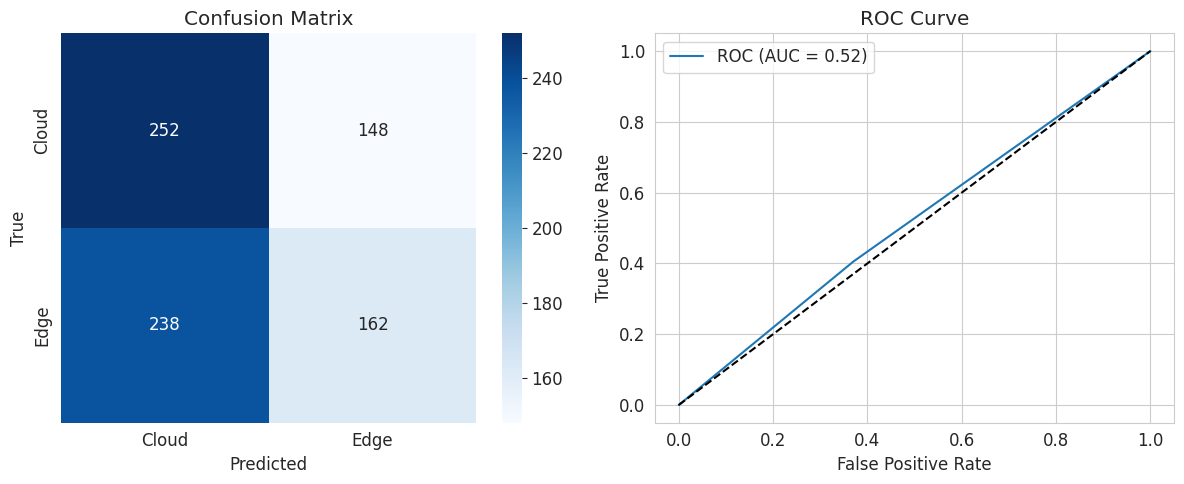

In [ ]:
def run_full_experiment():

    console = Console()

    # Cleanup old files
    for f in ["tier1_scheduler_new.zip", "tier2_scheduler_new.zip",
             "schedule_hrl.json", "schedule_cloud.json", "schedule_edge.json"]:
        if os.path.exists(f):
            os.remove(f)

    # Train GNN
    console.print("\n[bold]Phase 1: Training GNN[/bold]")
    trainer = GNNTrainer("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth")
    trainer.train(epochs=120)

    # Train and evaluate scheduler
    console.print("\n[bold]Phase 2: Training Scheduler[/bold]")
    scheduler = WorkflowScheduler("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth")
    """scheduler.train_tier1(timesteps=31000)
    scheduler.train_tier2(timesteps=20000)"""
    scheduler.train_tier1(timesteps=20000)
    scheduler.train_tier2(timesteps=10000)

    # Evaluate
    console.print("\n[bold]Phase 3: Evaluation[/bold]")
    scheduler.validate()
    scheduler.run_baselines()
    scheduler.present_results()

    # Enhanced metrics
    console.print("\n[bold]Phase 4: Detailed Metrics[/bold]")
    calculate_and_plot_metrics("balanced_montage_dag.json", "schedule_hrl.json")

# Execute
run_full_experiment()

Phase 1: Training GNN

[17:31:08] Training GNN with embedding_dim=32...                                 <ipython-input-18-401e2e266333>:87

           Using device: cpu                                                     <ipython-input-18-401e2e266333>:89

           Epoch 2/120: Loss=1.3224, Pos Sim=0.8191, Neg Sim=0.8247, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0174                                                                                              

           Epoch 4/120: Loss=1.0932, Pos Sim=0.8182, Neg Sim=0.7583, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0123                                                                                              

           Epoch 6/120: Loss=0.8305, Pos Sim=0.8249, Neg Sim=0.7919, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0088                                                                                              

           Epoch 8/120: Loss=0.8280, Pos Sim=0.8199, Neg Sim=0.7902, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0073                                                                                              

           Epoch 10/120: Loss=0.6614, Pos Sim=0.8207, Neg Sim=0.8029, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0049                                                                                              

           Epoch 12/120: Loss=0.6174, Pos Sim=0.8313, Neg Sim=0.8155, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0039                                                                                              

           Epoch 14/120: Loss=0.5773, Pos Sim=0.8307, Neg Sim=0.8127, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0035                                                                                              

           Epoch 16/120: Loss=0.5395, Pos Sim=0.8328, Neg Sim=0.8400, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0028                                                                                              

           Epoch 18/120: Loss=0.5798, Pos Sim=0.8360, Neg Sim=0.8179, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0026                                                                                              

           Epoch 20/120: Loss=0.5267, Pos Sim=0.8458, Neg Sim=0.8128, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0021                                                                                              

           Epoch 22/120: Loss=0.5293, Pos Sim=0.8512, Neg Sim=0.8156, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0019                                                                                              

           Epoch 24/120: Loss=0.5348, Pos Sim=0.8582, Neg Sim=0.7863, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0016                                                                                              

           Epoch 26/120: Loss=0.5546, Pos Sim=0.8610, Neg Sim=0.8427, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0014                                                                                              

           Epoch 28/120: Loss=0.5305, Pos Sim=0.8633, Neg Sim=0.8302, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0013                                                                                              

           Epoch 30/120: Loss=0.5116, Pos Sim=0.8723, Neg Sim=0.8165, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0012                                                                                              

           Epoch 32/120: Loss=0.5134, Pos Sim=0.8713, Neg Sim=0.8574, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0011                                                                                              

           Epoch 34/120: Loss=0.5286, Pos Sim=0.8680, Neg Sim=0.8533, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0010                                                                                              

           Epoch 36/120: Loss=0.5208, Pos Sim=0.8755, Neg Sim=0.8678, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0010                                                                                              

           Epoch 38/120: Loss=0.5166, Pos Sim=0.8807, Neg Sim=0.8573, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0009                                                                                              

[17:31:09] Epoch 40/120: Loss=0.5253, Pos Sim=0.8728, Neg Sim=0.7943, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0008                                                                                              

           Epoch 42/120: Loss=0.5066, Pos Sim=0.8768, Neg Sim=0.8919, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0008                                                                                              

           Epoch 44/120: Loss=0.5159, Pos Sim=0.8846, Neg Sim=0.8195, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 46/120: Loss=0.5114, Pos Sim=0.8825, Neg Sim=0.8218, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 48/120: Loss=0.5093, Pos Sim=0.8839, Neg Sim=0.8924, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

           Epoch 50/120: Loss=0.5103, Pos Sim=0.8834, Neg Sim=0.8693, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 52/120: Loss=0.5051, Pos Sim=0.8810, Neg Sim=0.8722, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

           Epoch 54/120: Loss=0.5035, Pos Sim=0.8810, Neg Sim=0.8708, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 56/120: Loss=0.5104, Pos Sim=0.8837, Neg Sim=0.8454, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 58/120: Loss=0.5157, Pos Sim=0.8766, Neg Sim=0.8869, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 60/120: Loss=0.5050, Pos Sim=0.8835, Neg Sim=0.8480, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 62/120: Loss=0.5106, Pos Sim=0.8815, Neg Sim=0.8975, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 64/120: Loss=0.5087, Pos Sim=0.8816, Neg Sim=0.8939, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 66/120: Loss=0.5123, Pos Sim=0.8835, Neg Sim=0.8580, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 68/120: Loss=0.5033, Pos Sim=0.8850, Neg Sim=0.8746, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 70/120: Loss=0.5073, Pos Sim=0.8842, Neg Sim=0.8606, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 72/120: Loss=0.5048, Pos Sim=0.8787, Neg Sim=0.8828, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 74/120: Loss=0.5012, Pos Sim=0.8809, Neg Sim=0.8367, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 76/120: Loss=0.5067, Pos Sim=0.8773, Neg Sim=0.8485, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 78/120: Loss=0.4993, Pos Sim=0.8784, Neg Sim=0.8412, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 80/120: Loss=0.5026, Pos Sim=0.8752, Neg Sim=0.9057, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 82/120: Loss=0.5074, Pos Sim=0.8761, Neg Sim=0.8528, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 84/120: Loss=0.5131, Pos Sim=0.8703, Neg Sim=0.8600, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 86/120: Loss=0.5023, Pos Sim=0.8791, Neg Sim=0.9067, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 88/120: Loss=0.5069, Pos Sim=0.8753, Neg Sim=0.8905, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 90/120: Loss=0.5069, Pos Sim=0.8631, Neg Sim=0.8767, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

[17:31:10] Epoch 92/120: Loss=0.5064, Pos Sim=0.8758, Neg Sim=0.7761, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 94/120: Loss=0.5013, Pos Sim=0.8717, Neg Sim=0.8448, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 96/120: Loss=0.5065, Pos Sim=0.8667, Neg Sim=0.7791, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 98/120: Loss=0.5028, Pos Sim=0.8661, Neg Sim=0.8311, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 100/120: Loss=0.5058, Pos Sim=0.8706, Neg Sim=0.8487, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 102/120: Loss=0.5062, Pos Sim=0.8694, Neg Sim=0.7831, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 104/120: Loss=0.5049, Pos Sim=0.8705, Neg Sim=0.8452, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 106/120: Loss=0.5029, Pos Sim=0.8529, Neg Sim=0.8640, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 108/120: Loss=0.5052, Pos Sim=0.8699, Neg Sim=0.8659, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 110/120: Loss=0.5053, Pos Sim=0.8667, Neg Sim=0.7794, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 112/120: Loss=0.5057, Pos Sim=0.8668, Neg Sim=0.8352, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 114/120: Loss=0.4999, Pos Sim=0.8671, Neg Sim=0.8942, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0001                                                                                              

           Epoch 116/120: Loss=0.4985, Pos Sim=0.8724, Neg Sim=0.8648, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 118/120: Loss=0.5038, Pos Sim=0.8595, Neg Sim=0.8285, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 120/120: Loss=0.5000, Pos Sim=0.8709, Neg Sim=0.8296, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

[17:31:11] Saved embeddings to dag_embeddings_uncert.pth                        <ipython-input-18-401e2e266333>:118

           Saved GNN model to gnn_model.pth                                     <ipython-input-18-401e2e266333>:119

           Final Metrics: Pos Sim=0.9761, Neg Sim=0.9699, Emb Var=0.0000        <ipython-input-18-401e2e266333>:121

Phase 2: Training Scheduler

[17:31:11] Training Tier 1...                                                    <ipython-input-11-3c121afbd0c5>:55

[17:31:50] Tier 1 training complete                                              <ipython-input-11-3c121afbd0c5>:62

           Training Tier 2...                                                    <ipython-input-11-3c121afbd0c5>:77

[17:33:38] Tier 2 training complete                                             <ipython-input-11-3c121afbd0c5>:124

Phase 3: Evaluation

           Saved schedule with 800 tasks to schedule_hrl.json                   <ipython-input-11-3c121afbd0c5>:278

           Validation for hrl completed                                         <ipython-input-11-3c121afbd0c5>:248

           Saved schedule with 800 tasks to schedule_cloud.json                 <ipython-input-11-3c121afbd0c5>:278

           Validation for cloud completed                                       <ipython-input-11-3c121afbd0c5>:248

[17:33:39] Saved schedule with 800 tasks to schedule_edge.json                  <ipython-input-11-3c121afbd0c5>:278

           Validation for edge completed                                        <ipython-input-11-3c121afbd0c5>:248

 Validation Metrics (Training: CyberShake, Validation: Montage) 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃          Metric          ┃   HRL    ┃ Cloud-Only ┃ Edge-Only ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│         DAG Used         │ Montage  │  Montage   │  Montage  │
│       Makespan (s)       │  161.52  │   209.01   │  208.01   │
│    Avg Exec Time (s)     │   4.78   │    4.79    │   2.77    │
│    Avg Energy (units)    │  42.85   │   61.38    │   12.89   │
│       Avg Cost ($)       │   0.34   │    0.48    │   0.14    │
│    SLA Compliance (%)    │ 100.00%  │  100.00%   │  100.00%  │
│     Cloud Ratio (%)      │  41.12%  │  100.00%   │   0.00%   │
│   Throughput (tasks/s)   │   4.95   │    3.83    │   3.85    │
│     Avg Queue Length     │  113.51  │   358.54   │  359.86   │
│ Cloud Load Balance (std) │   3.58   │   51.03    │   0.00    │
│ Edge Load Balance (std)  │   0.65   │    0.00    │   56.45   │
│   Avg Edge Battery (%)   │  48.26   │   100.00   │   9.70    │
│        Avg Reward        │ -1450.43 │   28.68    │   29.30   │
│     Tasks Completed      │ 800/800  │  800/800   │  800/800  │
└──────────────────────────┴──────────┴────────────┴───────────┘

[17:33:40] Saved metrics comparison plot                                        <ipython-input-11-3c121afbd0c5>:376

           Saved placement distribution plot                                    <ipython-input-11-3c121afbd0c5>:386

           Saved load balance plot                                              <ipython-input-11-3c121afbd0c5>:402

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (HRL, Montage DAG)                                                                     

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 329 (41.1%)                                        <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 471 (58.9%)                                         <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 4.78s                               <ipython-input-11-3c121afbd0c5>:337

             Task Placements (HRL)              
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   cloud   │   2    │     5.00      │
│ ID00421 │   cloud   │   4    │     5.00      │
│ ID00482 │   cloud   │   1    │     5.00      │
│ ID00142 │   cloud   │   2    │     5.00      │
│ ID00664 │   cloud   │   2    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_hrl.json                             <ipython-input-11-3c121afbd0c5>:344

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (Cloud-Only, Montage DAG)                                                              

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 800 (100.0%)                                       <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 0 (0.0%)                                            <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 4.79s                               <ipython-input-11-3c121afbd0c5>:337

          Task Placements (Cloud-Only)          
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   cloud   │   4    │     5.00      │
│ ID00421 │   cloud   │   3    │     5.00      │
│ ID00482 │   cloud   │   3    │     5.00      │
│ ID00142 │   cloud   │   1    │     5.00      │
│ ID00664 │   cloud   │   3    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_cloud.json                           <ipython-input-11-3c121afbd0c5>:344

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (Edge-Only, Montage DAG)                                                               

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 0 (0.0%)                                           <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 800 (100.0%)                                        <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 2.77s                               <ipython-input-11-3c121afbd0c5>:337

          Task Placements (Edge-Only)           
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   edge    │   3    │     5.00      │
│ ID00421 │   edge    │   4    │     2.20      │
│ ID00482 │   edge    │   3    │     5.00      │
│ ID00142 │   edge    │   4    │     2.30      │
│ ID00664 │   edge    │   3    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_edge.json                            <ipython-input-11-3c121afbd0c5>:344

Phase 4: Detailed Metrics

  Placement Metrics   
┏━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric    ┃  Value ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│ Precision │ 0.5180 │
│ Recall    │ 0.6100 │
│ F1        │ 0.5603 │
│ Accuracy  │ 0.5212 │
│ Roc_Auc   │ 0.5212 │
└───────────┴────────┘

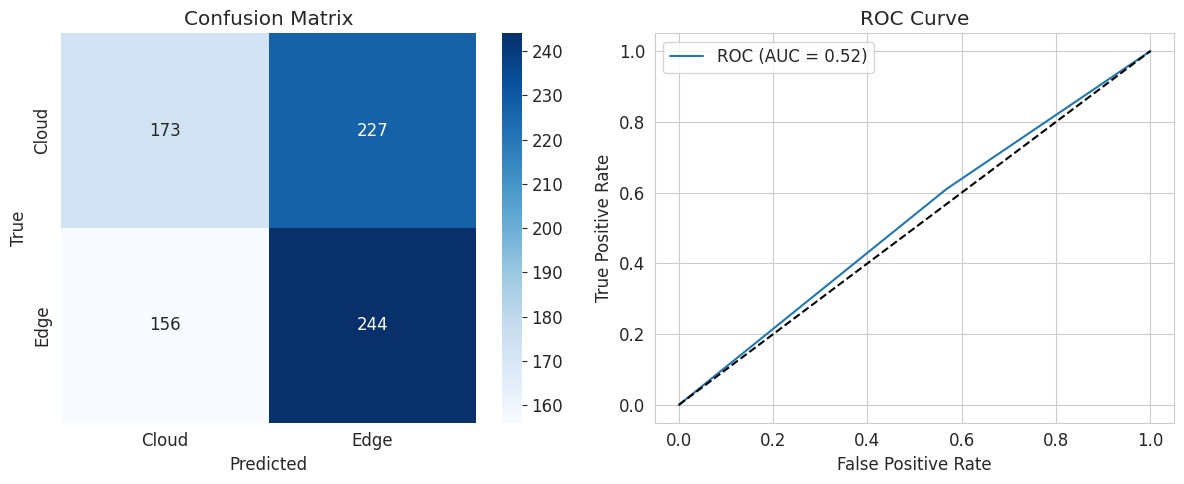

In [ ]:
def run_full_experiment():

    console = Console()

    # Cleanup old files
    for f in ["tier1_scheduler_new.zip", "tier2_scheduler_new.zip",
             "schedule_hrl.json", "schedule_cloud.json", "schedule_edge.json"]:
        if os.path.exists(f):
            os.remove(f)

    # Train GNN
    console.print("\n[bold]Phase 1: Training GNN[/bold]")
    trainer = GNNTrainer("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth")
    trainer.train(epochs=120)

    # Train and evaluate scheduler
    console.print("\n[bold]Phase 2: Training Scheduler[/bold]")
    scheduler = WorkflowScheduler("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth")
    """scheduler.train_tier1(timesteps=31000)
    scheduler.train_tier2(timesteps=20000)"""
    scheduler.train_tier1(timesteps=25000)
    scheduler.train_tier2(timesteps=12000)

    # Evaluate
    console.print("\n[bold]Phase 3: Evaluation[/bold]")
    scheduler.validate()
    scheduler.run_baselines()
    scheduler.present_results()

    # Enhanced metrics
    console.print("\n[bold]Phase 4: Detailed Metrics[/bold]")
    calculate_and_plot_metrics("balanced_montage_dag.json", "schedule_hrl.json")

# Execute
run_full_experiment()

Phase 1: Training GNN

[17:34:08] Training GNN with embedding_dim=32...                                 <ipython-input-18-401e2e266333>:87

           Using device: cpu                                                     <ipython-input-18-401e2e266333>:89

           Epoch 2/120: Loss=1.0265, Pos Sim=0.8272, Neg Sim=0.8188, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0124                                                                                              

           Epoch 4/120: Loss=0.8803, Pos Sim=0.8285, Neg Sim=0.8182, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0100                                                                                              

           Epoch 6/120: Loss=0.8251, Pos Sim=0.8378, Neg Sim=0.8073, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0075                                                                                              

           Epoch 8/120: Loss=0.6649, Pos Sim=0.8443, Neg Sim=0.8017, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0056                                                                                              

           Epoch 10/120: Loss=0.6338, Pos Sim=0.8544, Neg Sim=0.8118, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0044                                                                                              

           Epoch 12/120: Loss=0.6016, Pos Sim=0.8591, Neg Sim=0.8372, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0038                                                                                              

           Epoch 14/120: Loss=0.6091, Pos Sim=0.8712, Neg Sim=0.8545, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0031                                                                                              

           Epoch 16/120: Loss=0.5411, Pos Sim=0.8761, Neg Sim=0.8637, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0026                                                                                              

           Epoch 18/120: Loss=0.5443, Pos Sim=0.8824, Neg Sim=0.8246, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0021                                                                                              

           Epoch 20/120: Loss=0.5405, Pos Sim=0.8817, Neg Sim=0.8414, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0021                                                                                              

           Epoch 22/120: Loss=0.5423, Pos Sim=0.8892, Neg Sim=0.8370, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0016                                                                                              

           Epoch 24/120: Loss=0.5390, Pos Sim=0.8903, Neg Sim=0.8545, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0016                                                                                              

           Epoch 26/120: Loss=0.5407, Pos Sim=0.8902, Neg Sim=0.8858, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0015                                                                                              

           Epoch 28/120: Loss=0.5395, Pos Sim=0.8940, Neg Sim=0.8950, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0012                                                                                              

[17:34:09] Epoch 30/120: Loss=0.5262, Pos Sim=0.8930, Neg Sim=0.8931, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0012                                                                                              

           Epoch 32/120: Loss=0.5239, Pos Sim=0.8919, Neg Sim=0.8578, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0011                                                                                              

           Epoch 34/120: Loss=0.5082, Pos Sim=0.8970, Neg Sim=0.8258, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0009                                                                                              

           Epoch 36/120: Loss=0.5289, Pos Sim=0.8969, Neg Sim=0.8687, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0010                                                                                              

           Epoch 38/120: Loss=0.5233, Pos Sim=0.8957, Neg Sim=0.8866, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0009                                                                                              

           Epoch 40/120: Loss=0.5177, Pos Sim=0.8981, Neg Sim=0.8808, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0008                                                                                              

           Epoch 42/120: Loss=0.5176, Pos Sim=0.9016, Neg Sim=0.8452, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 44/120: Loss=0.5204, Pos Sim=0.8998, Neg Sim=0.9369, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 46/120: Loss=0.5109, Pos Sim=0.8981, Neg Sim=0.8749, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 48/120: Loss=0.5173, Pos Sim=0.8952, Neg Sim=0.8748, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

           Epoch 50/120: Loss=0.5068, Pos Sim=0.9005, Neg Sim=0.8782, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

           Epoch 52/120: Loss=0.5050, Pos Sim=0.8983, Neg Sim=0.8791, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

           Epoch 54/120: Loss=0.5161, Pos Sim=0.8990, Neg Sim=0.9175, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 56/120: Loss=0.5034, Pos Sim=0.8968, Neg Sim=0.8865, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 58/120: Loss=0.5083, Pos Sim=0.8939, Neg Sim=0.8748, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 60/120: Loss=0.5098, Pos Sim=0.9001, Neg Sim=0.8627, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 62/120: Loss=0.5105, Pos Sim=0.8919, Neg Sim=0.8929, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 64/120: Loss=0.5090, Pos Sim=0.8934, Neg Sim=0.8542, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 66/120: Loss=0.5097, Pos Sim=0.8911, Neg Sim=0.8493, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 68/120: Loss=0.4991, Pos Sim=0.8919, Neg Sim=0.8668, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 70/120: Loss=0.5149, Pos Sim=0.8885, Neg Sim=0.8561, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 72/120: Loss=0.5063, Pos Sim=0.8920, Neg Sim=0.8688, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 74/120: Loss=0.5068, Pos Sim=0.8885, Neg Sim=0.8639, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 76/120: Loss=0.5095, Pos Sim=0.8881, Neg Sim=0.8476, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 78/120: Loss=0.5109, Pos Sim=0.8845, Neg Sim=0.8598, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

[17:34:10] Epoch 80/120: Loss=0.5064, Pos Sim=0.8869, Neg Sim=0.8845, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 82/120: Loss=0.5059, Pos Sim=0.8865, Neg Sim=0.9099, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 84/120: Loss=0.5065, Pos Sim=0.8838, Neg Sim=0.8422, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 86/120: Loss=0.4971, Pos Sim=0.8781, Neg Sim=0.8660, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 88/120: Loss=0.5031, Pos Sim=0.8803, Neg Sim=0.8458, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 90/120: Loss=0.5082, Pos Sim=0.8766, Neg Sim=0.8627, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 92/120: Loss=0.5066, Pos Sim=0.8797, Neg Sim=0.8520, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 94/120: Loss=0.5069, Pos Sim=0.8808, Neg Sim=0.8757, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 96/120: Loss=0.5061, Pos Sim=0.8660, Neg Sim=0.8471, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 98/120: Loss=0.5073, Pos Sim=0.8768, Neg Sim=0.8479, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 100/120: Loss=0.5085, Pos Sim=0.8705, Neg Sim=0.7585, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 102/120: Loss=0.5019, Pos Sim=0.8649, Neg Sim=0.8698, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 104/120: Loss=0.5054, Pos Sim=0.8731, Neg Sim=0.8016, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 106/120: Loss=0.5068, Pos Sim=0.8698, Neg Sim=0.8787, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 108/120: Loss=0.5035, Pos Sim=0.8658, Neg Sim=0.8388, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 110/120: Loss=0.5063, Pos Sim=0.8564, Neg Sim=0.8092, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 112/120: Loss=0.5045, Pos Sim=0.8698, Neg Sim=0.8022, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 114/120: Loss=0.4999, Pos Sim=0.8569, Neg Sim=0.7613, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 116/120: Loss=0.5067, Pos Sim=0.8551, Neg Sim=0.8632, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 118/120: Loss=0.5035, Pos Sim=0.8613, Neg Sim=0.8717, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 120/120: Loss=0.5055, Pos Sim=0.8543, Neg Sim=0.8280, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Saved embeddings to dag_embeddings_uncert.pth                        <ipython-input-18-401e2e266333>:118

           Saved GNN model to gnn_model.pth                                     <ipython-input-18-401e2e266333>:119

           Final Metrics: Pos Sim=0.9668, Neg Sim=0.9639, Emb Var=0.0000        <ipython-input-18-401e2e266333>:121

Phase 2: Training Scheduler

[17:34:11] Training Tier 1...                                                    <ipython-input-11-3c121afbd0c5>:55

[17:34:54] Tier 1 training complete                                              <ipython-input-11-3c121afbd0c5>:62

           Training Tier 2...                                                    <ipython-input-11-3c121afbd0c5>:77

[17:36:23] Tier 2 training complete                                             <ipython-input-11-3c121afbd0c5>:124

Phase 3: Evaluation

           Saved schedule with 800 tasks to schedule_hrl.json                   <ipython-input-11-3c121afbd0c5>:278

           Validation for hrl completed                                         <ipython-input-11-3c121afbd0c5>:248

[17:36:24] Saved schedule with 800 tasks to schedule_cloud.json                 <ipython-input-11-3c121afbd0c5>:278

           Validation for cloud completed                                       <ipython-input-11-3c121afbd0c5>:248

           Saved schedule with 800 tasks to schedule_edge.json                  <ipython-input-11-3c121afbd0c5>:278

           Validation for edge completed                                        <ipython-input-11-3c121afbd0c5>:248

 Validation Metrics (Training: CyberShake, Validation: Montage) 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃          Metric          ┃   HRL    ┃ Cloud-Only ┃ Edge-Only ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│         DAG Used         │ Montage  │  Montage   │  Montage  │
│       Makespan (s)       │  164.02  │   209.01   │  208.01   │
│    Avg Exec Time (s)     │   4.78   │    4.79    │   2.76    │
│    Avg Energy (units)    │  44.75   │   62.79    │   14.42   │
│       Avg Cost ($)       │   0.34   │    0.48    │   0.14    │
│    SLA Compliance (%)    │ 100.00%  │  100.00%   │  100.00%  │
│     Cloud Ratio (%)      │  41.50%  │  100.00%   │   0.00%   │
│   Throughput (tasks/s)   │   4.88   │    3.83    │   3.85    │
│     Avg Queue Length     │  113.02  │   358.54   │  359.86   │
│ Cloud Load Balance (std) │   3.63   │   31.88    │   0.00    │
│ Edge Load Balance (std)  │   0.26   │    0.00    │   70.91   │
│   Avg Edge Battery (%)   │  31.80   │   100.00   │   9.20    │
│        Avg Reward        │ -1441.87 │   28.67    │   29.29   │
│     Tasks Completed      │ 800/800  │  800/800   │  800/800  │
└──────────────────────────┴──────────┴────────────┴───────────┘

[17:36:25] Saved metrics comparison plot                                        <ipython-input-11-3c121afbd0c5>:376

           Saved placement distribution plot                                    <ipython-input-11-3c121afbd0c5>:386

           Saved load balance plot                                              <ipython-input-11-3c121afbd0c5>:402

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (HRL, Montage DAG)                                                                     

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 332 (41.5%)                                        <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 468 (58.5%)                                         <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 4.78s                               <ipython-input-11-3c121afbd0c5>:337

             Task Placements (HRL)              
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   cloud   │   0    │     5.00      │
│ ID00421 │   cloud   │   1    │     5.00      │
│ ID00482 │   cloud   │   0    │     5.00      │
│ ID00142 │   cloud   │   0    │     5.00      │
│ ID00664 │   cloud   │   0    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_hrl.json                             <ipython-input-11-3c121afbd0c5>:344

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (Cloud-Only, Montage DAG)                                                              

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 800 (100.0%)                                       <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 0 (0.0%)                                            <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 4.79s                               <ipython-input-11-3c121afbd0c5>:337

          Task Placements (Cloud-Only)          
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   cloud   │   3    │     5.00      │
│ ID00421 │   cloud   │   2    │     5.00      │
│ ID00482 │   cloud   │   0    │     5.00      │
│ ID00142 │   cloud   │   0    │     5.00      │
│ ID00664 │   cloud   │   2    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_cloud.json                           <ipython-input-11-3c121afbd0c5>:344

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (Edge-Only, Montage DAG)                                                               

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 0 (0.0%)                                           <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 800 (100.0%)                                        <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 2.76s                               <ipython-input-11-3c121afbd0c5>:337

          Task Placements (Edge-Only)           
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   edge    │   4    │     5.00      │
│ ID00421 │   edge    │   3    │     2.20      │
│ ID00482 │   edge    │   3    │     5.00      │
│ ID00142 │   edge    │   3    │     2.30      │
│ ID00664 │   edge    │   3    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_edge.json                            <ipython-input-11-3c121afbd0c5>:344

Phase 4: Detailed Metrics

  Placement Metrics   
┏━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric    ┃  Value ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│ Precision │ 0.5385 │
│ Recall    │ 0.6300 │
│ F1        │ 0.5806 │
│ Accuracy  │ 0.5450 │
│ Roc_Auc   │ 0.5450 │
└───────────┴────────┘

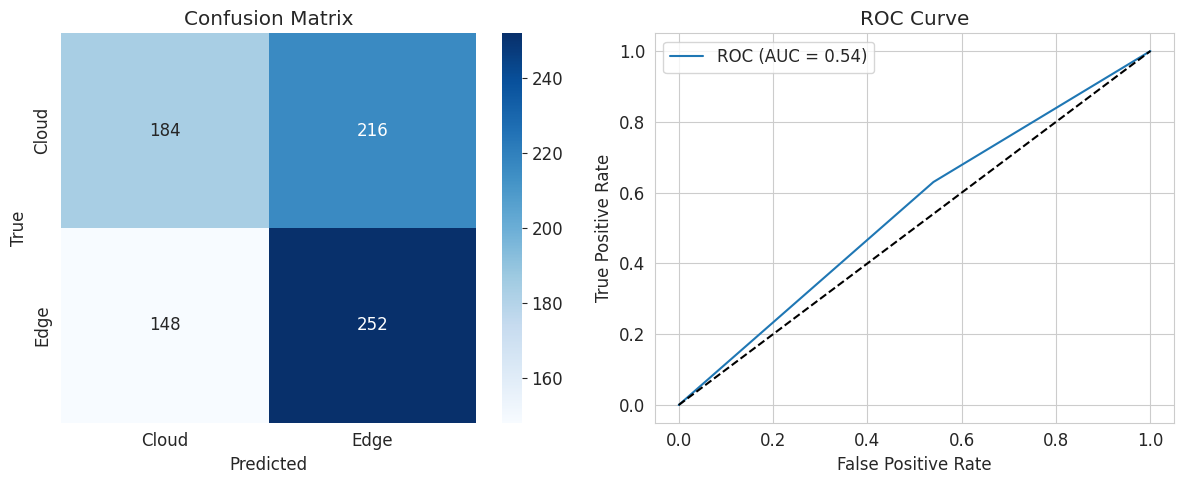

In [ ]:
#fair
def run_full_experiment():

    console = Console()

    # Cleanup old files
    for f in ["tier1_scheduler_new.zip", "tier2_scheduler_new.zip",
             "schedule_hrl.json", "schedule_cloud.json", "schedule_edge.json"]:
        if os.path.exists(f):
            os.remove(f)

    # Train GNN
    console.print("\n[bold]Phase 1: Training GNN[/bold]")
    trainer = GNNTrainer("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth")
    trainer.train(epochs=120)

    # Train and evaluate scheduler
    console.print("\n[bold]Phase 2: Training Scheduler[/bold]")
    scheduler = WorkflowScheduler("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth")
    """scheduler.train_tier1(timesteps=31000)
    scheduler.train_tier2(timesteps=20000)"""
    scheduler.train_tier1(timesteps=28000)
    scheduler.train_tier2(timesteps=10000)

    # Evaluate
    console.print("\n[bold]Phase 3: Evaluation[/bold]")
    scheduler.validate()
    scheduler.run_baselines()
    scheduler.present_results()

    # Enhanced metrics
    console.print("\n[bold]Phase 4: Detailed Metrics[/bold]")
    calculate_and_plot_metrics("balanced_montage_dag.json", "schedule_hrl.json")

# Execute
run_full_experiment()

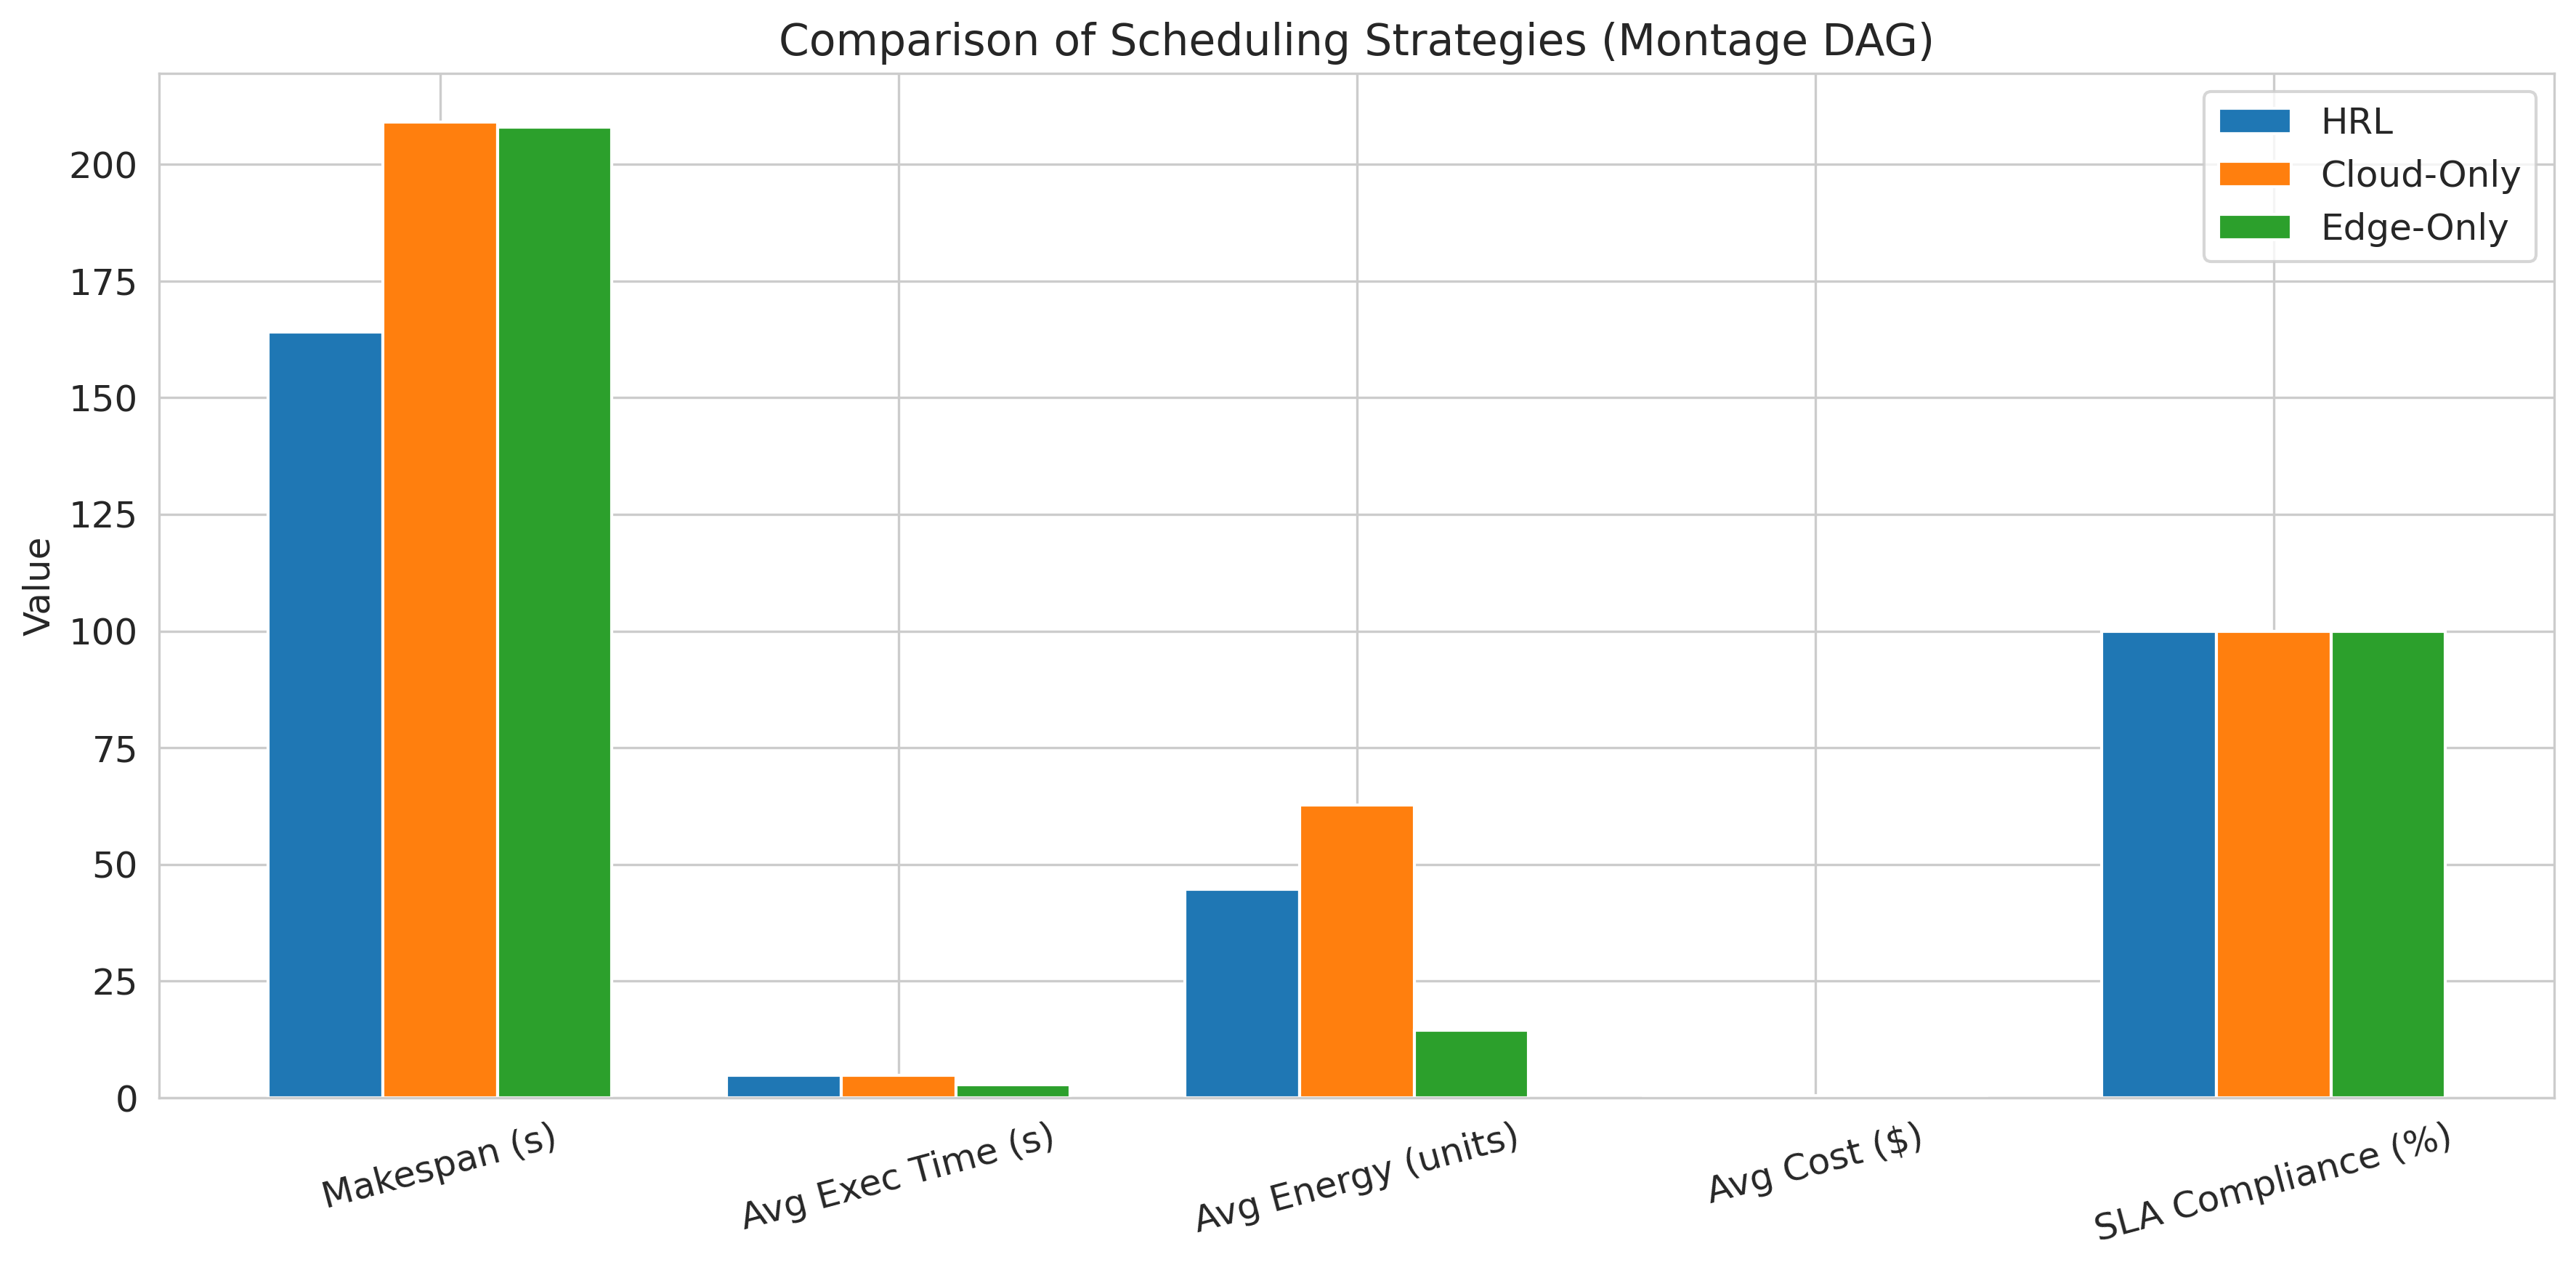

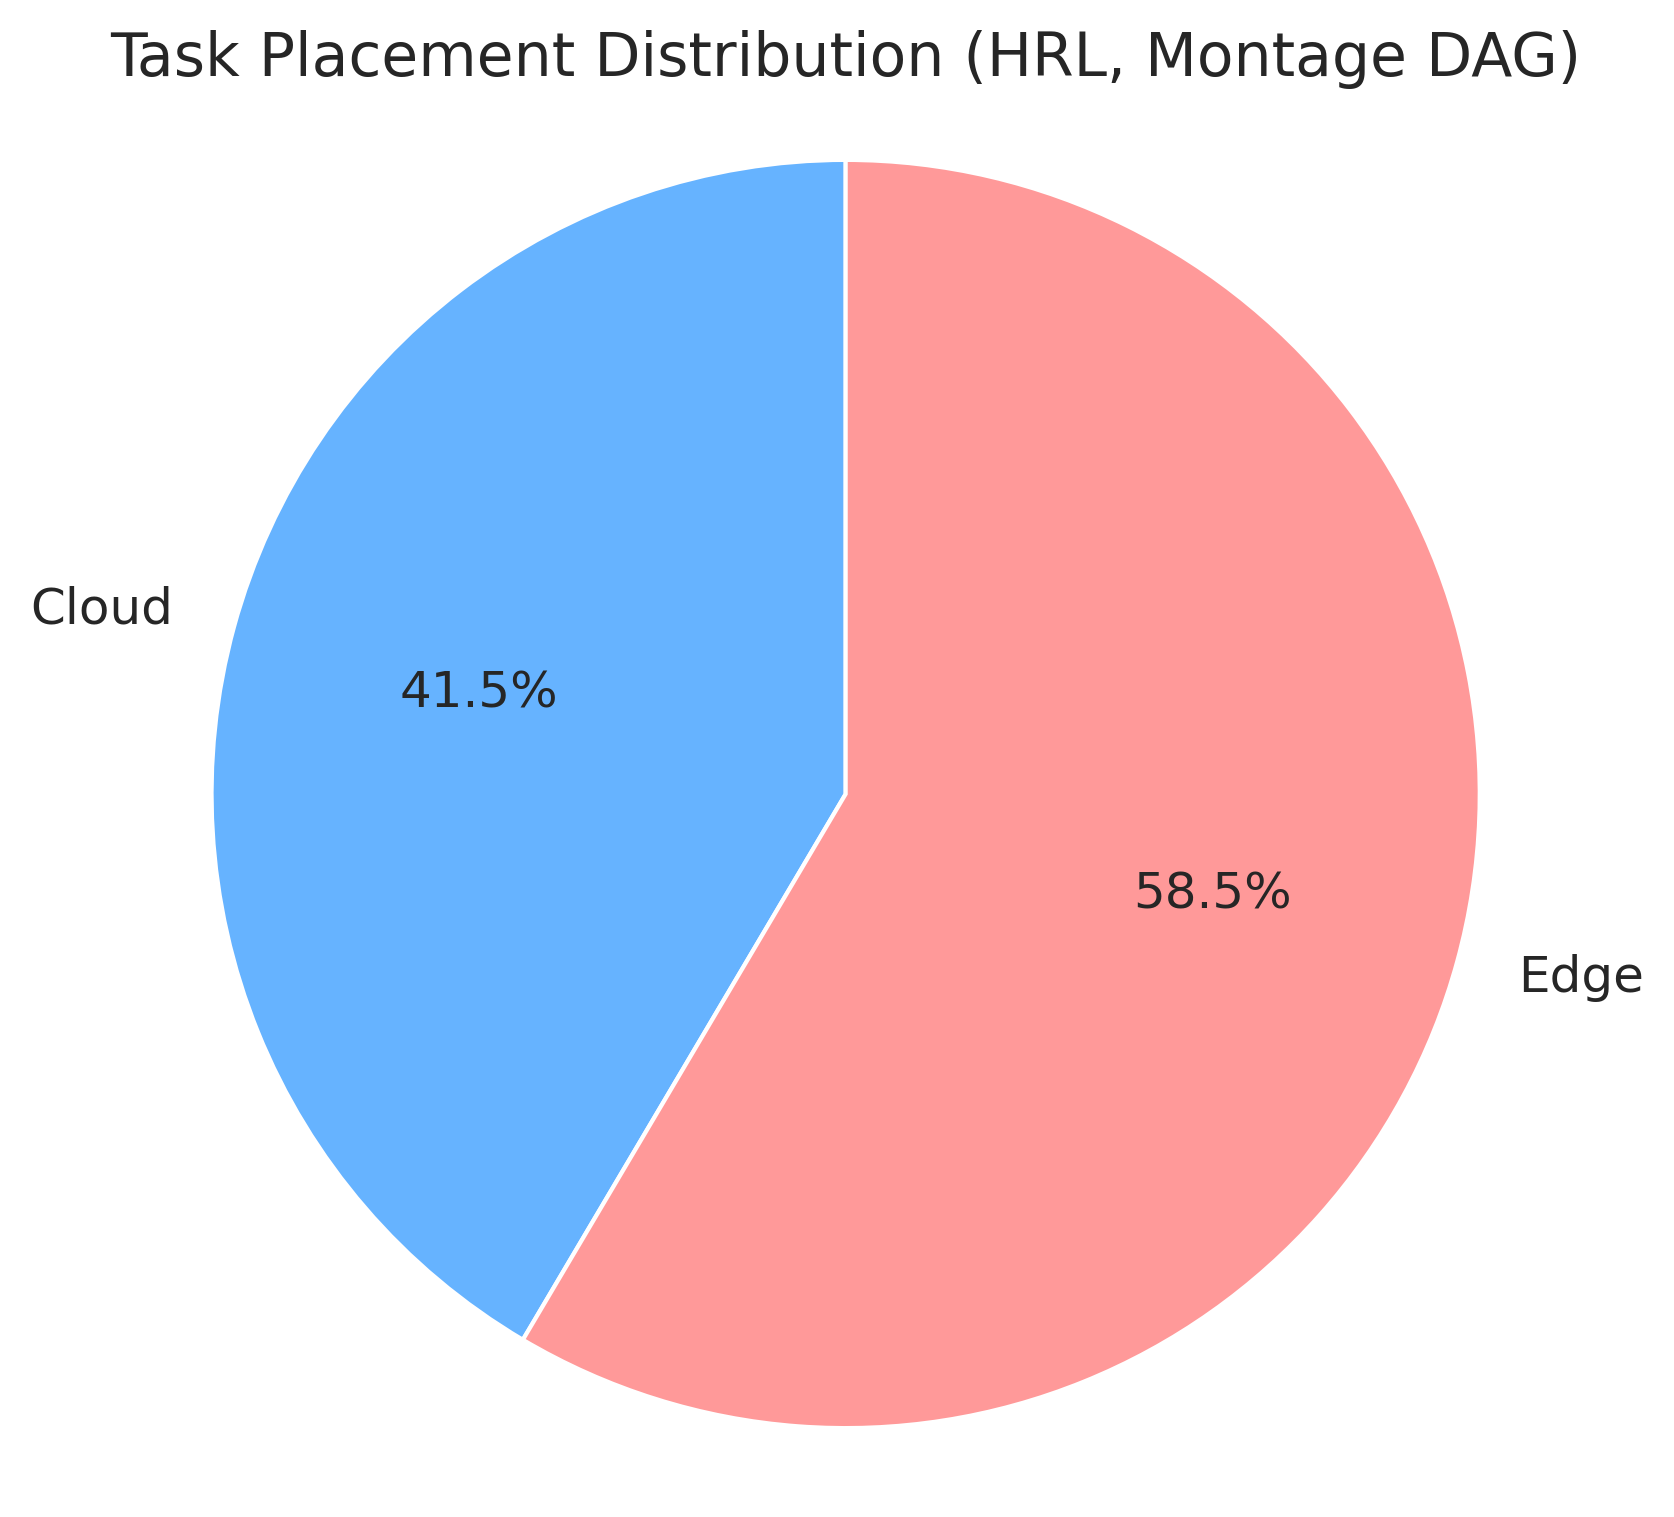

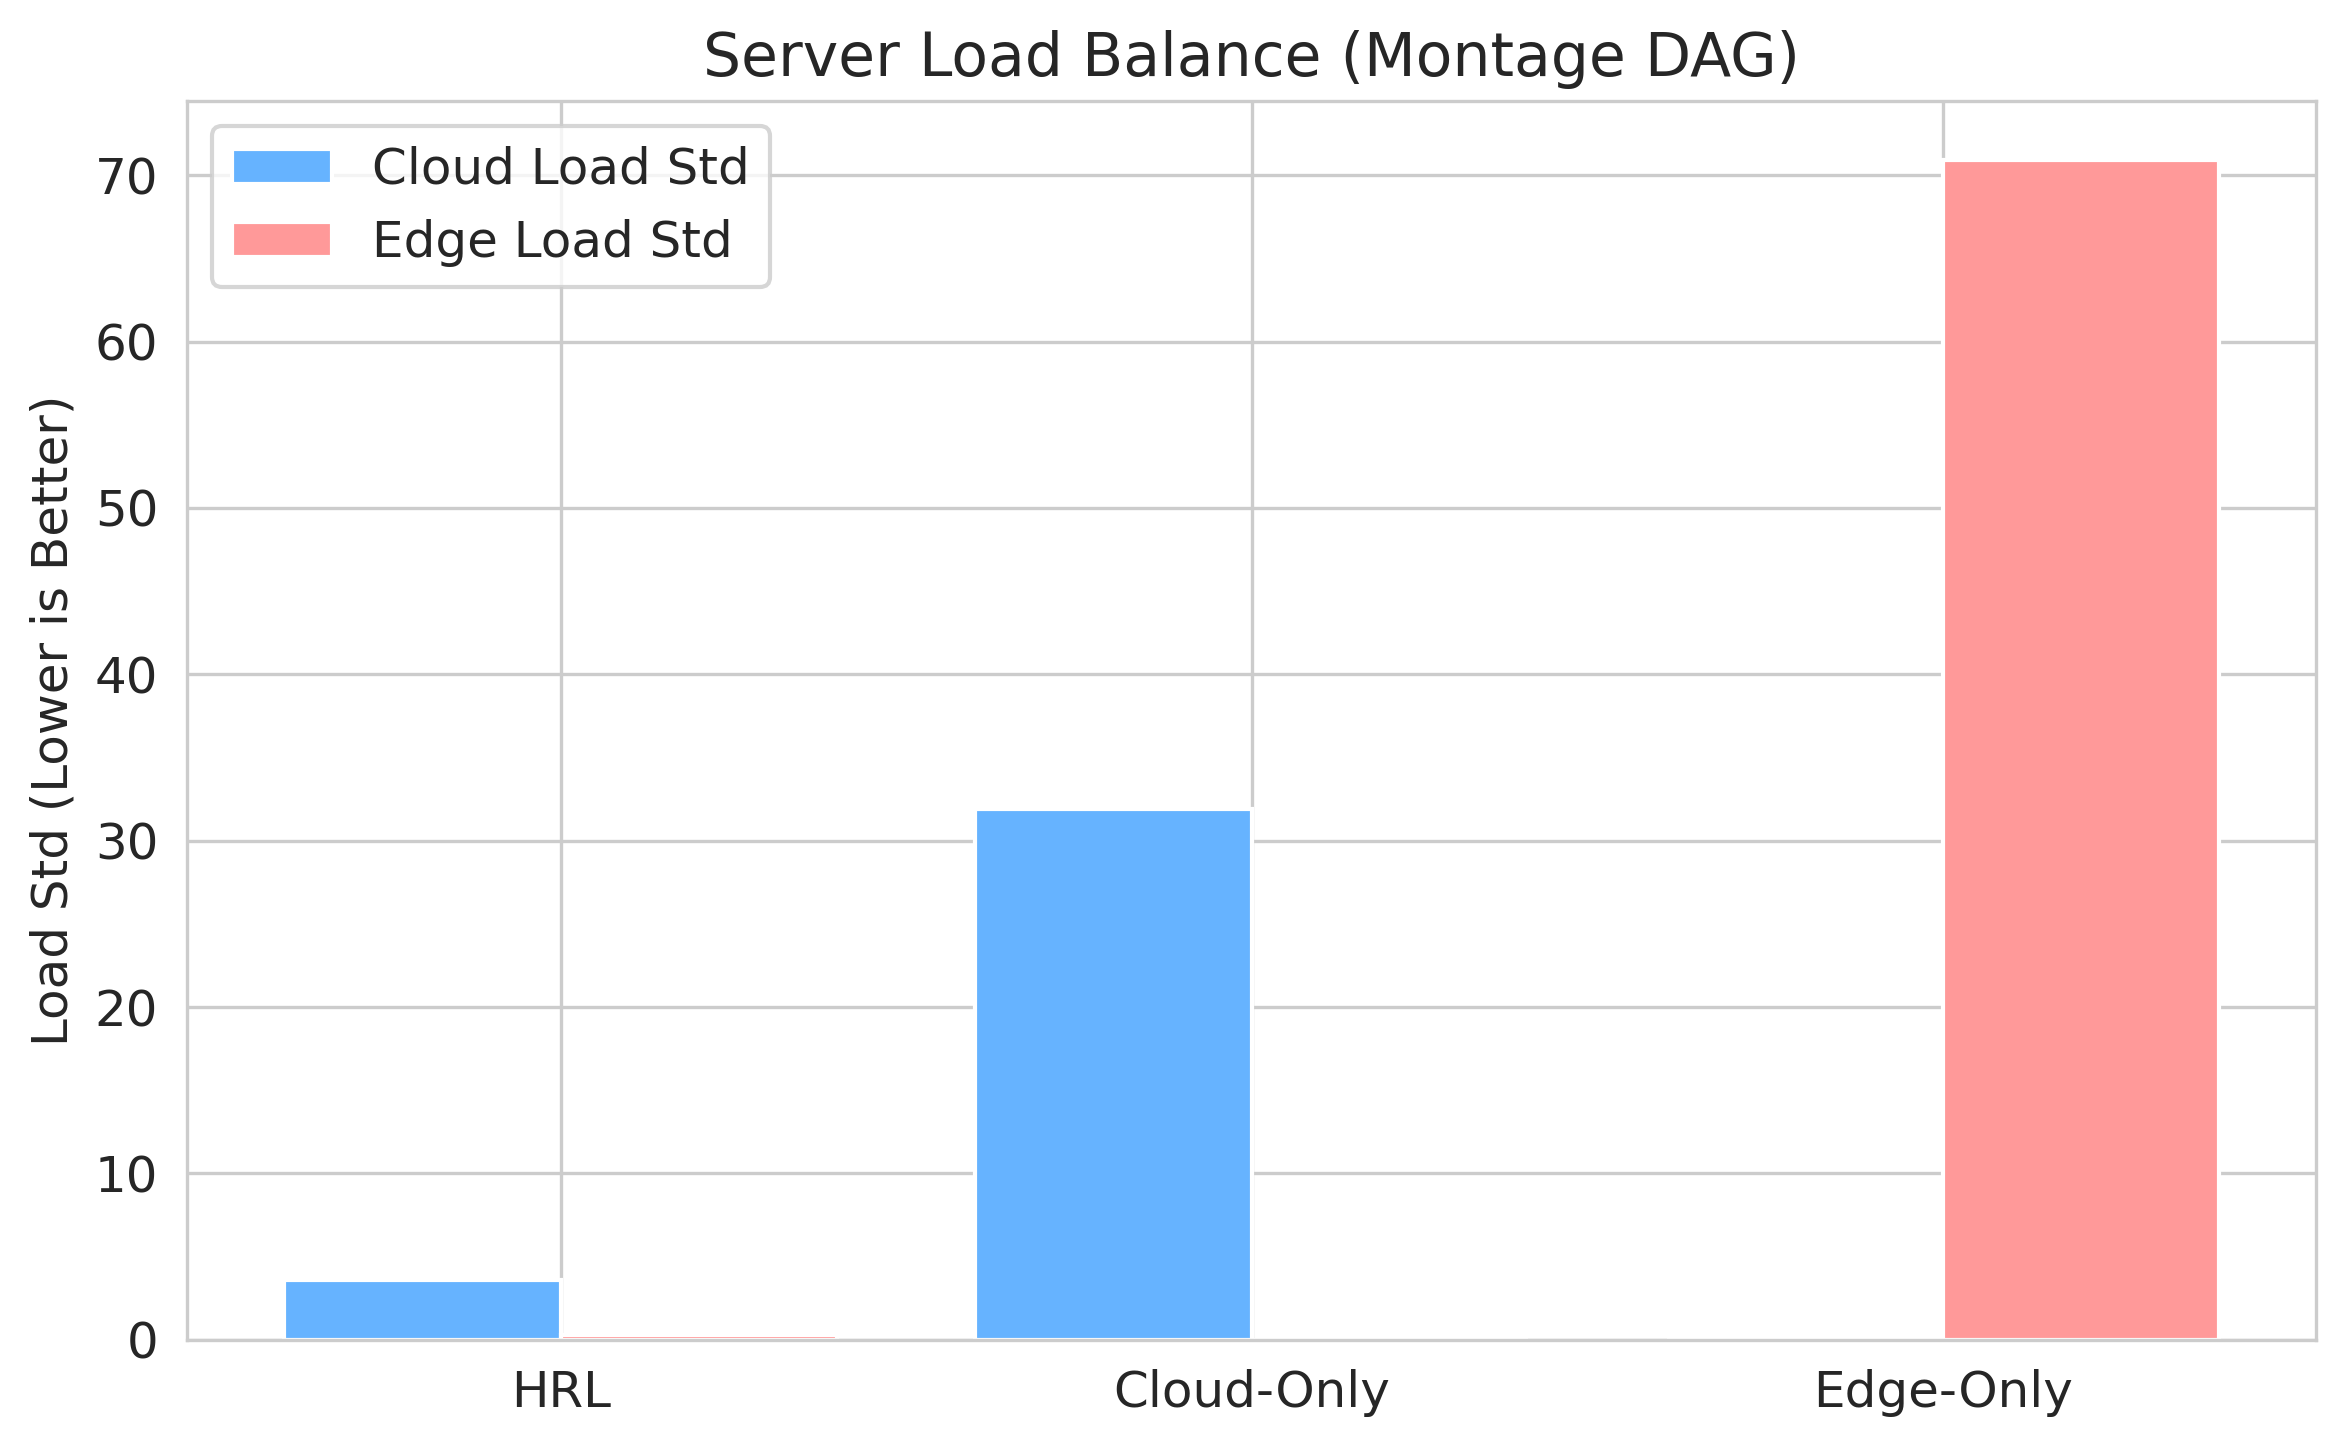

In [ ]:
#fair
#showing the visualisations seperately
from IPython.display import Image, display
import os

def show_pngs(max_width=300):
    """Displays PNG images with a specified maximum width."""
    image_paths = [
        "metrics_comparison.png",
        "placement_distribution.png",
        "load_balance.png"
    ]
    for image_path in image_paths:
        if os.path.exists(image_path):
            display(Image(filename=image_path, width=max_width))
        else:
            print(f"Warning: Image file not found: {image_path}")
show_pngs(max_width=600)

Phase 1: Training GNN

[18:31:00] Training GNN with embedding_dim=32...                                 <ipython-input-18-401e2e266333>:87

           Using device: cpu                                                     <ipython-input-18-401e2e266333>:89

           Epoch 2/120: Loss=1.1388, Pos Sim=0.8005, Neg Sim=0.7502, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0141                                                                                              

           Epoch 4/120: Loss=0.9246, Pos Sim=0.8099, Neg Sim=0.8578, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0104                                                                                              

           Epoch 6/120: Loss=0.7943, Pos Sim=0.8288, Neg Sim=0.7703, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0079                                                                                              

           Epoch 8/120: Loss=0.7319, Pos Sim=0.8423, Neg Sim=0.8070, Emb        <ipython-input-18-401e2e266333>:104
           Var=0.0065                                                                                              

           Epoch 10/120: Loss=0.6520, Pos Sim=0.8558, Neg Sim=0.8628, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0047                                                                                              

           Epoch 12/120: Loss=0.6164, Pos Sim=0.8589, Neg Sim=0.7816, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0038                                                                                              

           Epoch 14/120: Loss=0.5675, Pos Sim=0.8693, Neg Sim=0.8564, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0028                                                                                              

           Epoch 16/120: Loss=0.5638, Pos Sim=0.8721, Neg Sim=0.8382, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0026                                                                                              

           Epoch 18/120: Loss=0.5609, Pos Sim=0.8689, Neg Sim=0.8504, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0023                                                                                              

           Epoch 20/120: Loss=0.5294, Pos Sim=0.8772, Neg Sim=0.8647, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0020                                                                                              

           Epoch 22/120: Loss=0.5269, Pos Sim=0.8742, Neg Sim=0.8438, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0018                                                                                              

           Epoch 24/120: Loss=0.5284, Pos Sim=0.8794, Neg Sim=0.8818, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0015                                                                                              

           Epoch 26/120: Loss=0.5418, Pos Sim=0.8751, Neg Sim=0.8337, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0015                                                                                              

           Epoch 28/120: Loss=0.5258, Pos Sim=0.8777, Neg Sim=0.8293, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0013                                                                                              

           Epoch 30/120: Loss=0.5331, Pos Sim=0.8740, Neg Sim=0.8591, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0012                                                                                              

           Epoch 32/120: Loss=0.5287, Pos Sim=0.8819, Neg Sim=0.8669, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0011                                                                                              

           Epoch 34/120: Loss=0.5162, Pos Sim=0.8771, Neg Sim=0.8512, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0011                                                                                              

           Epoch 36/120: Loss=0.5133, Pos Sim=0.8816, Neg Sim=0.8076, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0009                                                                                              

           Epoch 38/120: Loss=0.5215, Pos Sim=0.8812, Neg Sim=0.8708, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0008                                                                                              

           Epoch 40/120: Loss=0.5179, Pos Sim=0.8922, Neg Sim=0.8981, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 42/120: Loss=0.5119, Pos Sim=0.8871, Neg Sim=0.8546, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 44/120: Loss=0.5089, Pos Sim=0.8884, Neg Sim=0.8766, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 46/120: Loss=0.5053, Pos Sim=0.8805, Neg Sim=0.8358, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0007                                                                                              

           Epoch 48/120: Loss=0.5104, Pos Sim=0.8863, Neg Sim=0.8624, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

           Epoch 50/120: Loss=0.5131, Pos Sim=0.8883, Neg Sim=0.8550, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

[18:31:01] Epoch 52/120: Loss=0.5129, Pos Sim=0.8852, Neg Sim=0.8509, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0006                                                                                              

           Epoch 54/120: Loss=0.5076, Pos Sim=0.8887, Neg Sim=0.8735, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 56/120: Loss=0.5138, Pos Sim=0.8933, Neg Sim=0.8991, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 58/120: Loss=0.5061, Pos Sim=0.8904, Neg Sim=0.8652, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 60/120: Loss=0.5080, Pos Sim=0.8865, Neg Sim=0.8326, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 62/120: Loss=0.5068, Pos Sim=0.8868, Neg Sim=0.8678, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0005                                                                                              

           Epoch 64/120: Loss=0.5089, Pos Sim=0.8875, Neg Sim=0.8563, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 66/120: Loss=0.5064, Pos Sim=0.8872, Neg Sim=0.8450, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 68/120: Loss=0.5010, Pos Sim=0.8868, Neg Sim=0.8151, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 70/120: Loss=0.5085, Pos Sim=0.8857, Neg Sim=0.8119, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 72/120: Loss=0.5065, Pos Sim=0.8861, Neg Sim=0.8657, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 74/120: Loss=0.5043, Pos Sim=0.8743, Neg Sim=0.8340, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 76/120: Loss=0.5079, Pos Sim=0.8751, Neg Sim=0.8757, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 78/120: Loss=0.5025, Pos Sim=0.8805, Neg Sim=0.8537, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0004                                                                                              

           Epoch 80/120: Loss=0.5106, Pos Sim=0.8803, Neg Sim=0.8647, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 82/120: Loss=0.5068, Pos Sim=0.8832, Neg Sim=0.8547, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 84/120: Loss=0.5024, Pos Sim=0.8817, Neg Sim=0.8597, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 86/120: Loss=0.5019, Pos Sim=0.8821, Neg Sim=0.8320, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 88/120: Loss=0.5053, Pos Sim=0.8844, Neg Sim=0.8597, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 90/120: Loss=0.4991, Pos Sim=0.8742, Neg Sim=0.8364, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 92/120: Loss=0.5045, Pos Sim=0.8814, Neg Sim=0.8542, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 94/120: Loss=0.5053, Pos Sim=0.8773, Neg Sim=0.8190, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 96/120: Loss=0.4986, Pos Sim=0.8699, Neg Sim=0.8655, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0003                                                                                              

           Epoch 98/120: Loss=0.5039, Pos Sim=0.8727, Neg Sim=0.8203, Emb       <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 100/120: Loss=0.5057, Pos Sim=0.8725, Neg Sim=0.8288, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 102/120: Loss=0.5034, Pos Sim=0.8624, Neg Sim=0.8424, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 104/120: Loss=0.5053, Pos Sim=0.8715, Neg Sim=0.8649, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 106/120: Loss=0.5043, Pos Sim=0.8706, Neg Sim=0.8195, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 108/120: Loss=0.5010, Pos Sim=0.8677, Neg Sim=0.8736, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 110/120: Loss=0.5027, Pos Sim=0.8595, Neg Sim=0.7863, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 112/120: Loss=0.5008, Pos Sim=0.8607, Neg Sim=0.8555, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 114/120: Loss=0.5044, Pos Sim=0.8627, Neg Sim=0.8396, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 116/120: Loss=0.5053, Pos Sim=0.8641, Neg Sim=0.8409, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

[18:31:02] Epoch 118/120: Loss=0.5028, Pos Sim=0.8667, Neg Sim=0.7935, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Epoch 120/120: Loss=0.5039, Pos Sim=0.8598, Neg Sim=0.8075, Emb      <ipython-input-18-401e2e266333>:104
           Var=0.0002                                                                                              

           Saved embeddings to dag_embeddings_uncert.pth                        <ipython-input-18-401e2e266333>:118

           Saved GNN model to gnn_model.pth                                     <ipython-input-18-401e2e266333>:119

           Final Metrics: Pos Sim=0.9868, Neg Sim=0.9881, Emb Var=0.0000        <ipython-input-18-401e2e266333>:121

Phase 2: Training Scheduler

[18:31:02] Training Tier 1...                                                    <ipython-input-11-3c121afbd0c5>:55

[18:31:48] Tier 1 training complete                                              <ipython-input-11-3c121afbd0c5>:62

           Training Tier 2...                                                    <ipython-input-11-3c121afbd0c5>:77

[18:34:46] Tier 2 training complete                                             <ipython-input-11-3c121afbd0c5>:124

Phase 3: Evaluation

           Saved schedule with 800 tasks to schedule_hrl.json                   <ipython-input-11-3c121afbd0c5>:278

           Validation for hrl completed                                         <ipython-input-11-3c121afbd0c5>:248

[18:34:47] Saved schedule with 800 tasks to schedule_cloud.json                 <ipython-input-11-3c121afbd0c5>:278

           Validation for cloud completed                                       <ipython-input-11-3c121afbd0c5>:248

           Saved schedule with 800 tasks to schedule_edge.json                  <ipython-input-11-3c121afbd0c5>:278

           Validation for edge completed                                        <ipython-input-11-3c121afbd0c5>:248

 Validation Metrics (Training: CyberShake, Validation: Montage) 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃          Metric          ┃   HRL    ┃ Cloud-Only ┃ Edge-Only ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│         DAG Used         │ Montage  │  Montage   │  Montage  │
│       Makespan (s)       │  158.52  │   209.01   │  208.01   │
│    Avg Exec Time (s)     │   4.79   │    4.79    │   2.76    │
│    Avg Energy (units)    │  19.90   │   63.88    │   13.89   │
│       Avg Cost ($)       │   0.24   │    0.48    │   0.14    │
│    SLA Compliance (%)    │ 100.00%  │  100.00%   │  100.00%  │
│     Cloud Ratio (%)      │  0.62%   │  100.00%   │   0.00%   │
│   Throughput (tasks/s)   │   5.05   │    3.83    │   3.85    │
│     Avg Queue Length     │  115.10  │   358.54   │  359.86   │
│ Cloud Load Balance (std) │   0.00   │   19.05    │   0.00    │
│ Edge Load Balance (std)  │   5.46   │    0.00    │   57.41   │
│   Avg Edge Battery (%)   │  12.00   │   100.00   │   9.70    │
│        Avg Reward        │ -1486.97 │   28.66    │   29.29   │
│     Tasks Completed      │ 800/800  │  800/800   │  800/800  │
└──────────────────────────┴──────────┴────────────┴───────────┘

           Saved metrics comparison plot                                        <ipython-input-11-3c121afbd0c5>:376

           Saved placement distribution plot                                    <ipython-input-11-3c121afbd0c5>:386

[18:34:48] Saved load balance plot                                              <ipython-input-11-3c121afbd0c5>:402

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (HRL, Montage DAG)                                                                     

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 5 (0.6%)                                           <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 795 (99.4%)                                         <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 4.79s                               <ipython-input-11-3c121afbd0c5>:337

             Task Placements (HRL)              
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   edge    │   1    │     5.00      │
│ ID00421 │   edge    │   0    │     5.00      │
│ ID00482 │   edge    │   0    │     5.00      │
│ ID00142 │   edge    │   1    │     5.00      │
│ ID00664 │   edge    │   1    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_hrl.json                             <ipython-input-11-3c121afbd0c5>:344

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (Cloud-Only, Montage DAG)                                                              

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 800 (100.0%)                                       <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 0 (0.0%)                                            <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 4.79s                               <ipython-input-11-3c121afbd0c5>:337

          Task Placements (Cloud-Only)          
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   cloud   │   1    │     5.00      │
│ ID00421 │   cloud   │   0    │     5.00      │
│ ID00482 │   cloud   │   3    │     5.00      │
│ ID00142 │   cloud   │   1    │     5.00      │
│ ID00664 │   cloud   │   1    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_cloud.json                           <ipython-input-11-3c121afbd0c5>:344

                                                                                <ipython-input-11-3c121afbd0c5>:333
           Schedule Summary (Edge-Only, Montage DAG)                                                               

           Total Tasks Scheduled: 800                                           <ipython-input-11-3c121afbd0c5>:334

           Cloud Placements: 0 (0.0%)                                           <ipython-input-11-3c121afbd0c5>:335

           Edge Placements: 800 (100.0%)                                        <ipython-input-11-3c121afbd0c5>:336

           Average Execution Time per Task: 2.76s                               <ipython-input-11-3c121afbd0c5>:337

          Task Placements (Edge-Only)           
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   edge    │   0    │     5.00      │
│ ID00421 │   edge    │   0    │     2.20      │
│ ID00482 │   edge    │   2    │     5.00      │
│ ID00142 │   edge    │   0    │     2.30      │
│ ID00664 │   edge    │   0    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_edge.json                            <ipython-input-11-3c121afbd0c5>:344

Phase 4: Detailed Metrics

  Placement Metrics   
┏━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric    ┃  Value ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│ Precision │ 0.5031 │
│ Recall    │ 1.0000 │
│ F1        │ 0.6695 │
│ Accuracy  │ 0.5062 │
│ Roc_Auc   │ 0.5062 │
└───────────┴────────┘

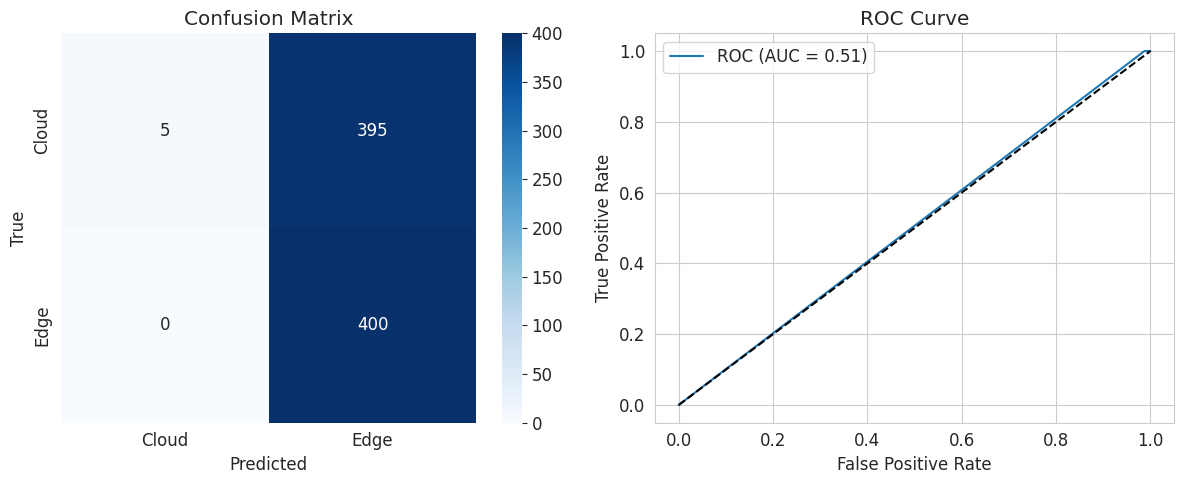

In [ ]:
#fair
def run_full_experiment():

    console = Console()

    # Cleanup old files
    for f in ["tier1_scheduler_new.zip", "tier2_scheduler_new.zip",
             "schedule_hrl.json", "schedule_cloud.json", "schedule_edge.json"]:
        if os.path.exists(f):
            os.remove(f)

    # Train GNN
    console.print("\n[bold]Phase 1: Training GNN[/bold]")
    trainer = GNNTrainer("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth")
    trainer.train(epochs=120)

    # Train and evaluate scheduler
    console.print("\n[bold]Phase 2: Training Scheduler[/bold]")
    scheduler = WorkflowScheduler("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth")
    """scheduler.train_tier1(timesteps=31000)
    scheduler.train_tier2(timesteps=20000)"""
    scheduler.train_tier1(timesteps=30000)
    scheduler.train_tier2(timesteps=20000)

    # Evaluate
    console.print("\n[bold]Phase 3: Evaluation[/bold]")
    scheduler.validate()
    scheduler.run_baselines()
    scheduler.present_results()

    # Enhanced metrics
    console.print("\n[bold]Phase 4: Detailed Metrics[/bold]")
    calculate_and_plot_metrics("balanced_montage_dag.json", "schedule_hrl.json")

# Execute
run_full_experiment()

In [ ]:
import json
import os
from rich.console import Console
from rich.table import Table

# Print execution time and placement for tasks from schedule JSONs
def print_schedule_details(modes=["hrl", "cloud", "edge"]):
    console = Console()
    for mode in modes:
        filename = f"schedule_{mode}.json"
        # Load schedule JSON
        with open(filename, "r") as f:
            schedule = json.load(f)  # Dict: [num_tasks] keys

        # Create table for display
        table = Table(title=f"Task Schedule ({mode.upper()}, Montage DAG)")
        table.add_column("Task ID", justify="center")
        table.add_column("Placement", justify="center")
        table.add_column("Execution Time (s)", justify="center")
        # Sort tasks by ID for consistent ordering
        sorted_tasks = sorted(schedule.items(), key=lambda x: x[0])  # List: [num_tasks, (task_id, dict)]
        for task_id, info in sorted_tasks:
            placement = info.get("placement", "N/A")
            exec_time = info.get("exec_time", 0.0)
            table.add_row(task_id, str(placement), f"{exec_time:.2f}")
        console.print(table)
        console.log(f"Displayed {len(schedule)} tasks for {mode.upper()}")

if __name__ == "__main__":
    # Execute for all modes
    print_schedule_details()  # Outputs tables for HRL, cloud, edge

      Task Schedule (HRL, Montage DAG)      
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ ID00001 │   edge    │        5.00        │
│ ID00003 │   edge    │        5.00        │
│ ID00004 │   edge    │        5.00        │
│ ID00005 │   edge    │        5.00        │
│ ID00007 │   edge    │        5.00        │
│ ID00010 │   edge    │        5.00        │
│ ID00011 │   edge    │        5.00        │
│ ID00012 │   edge    │        4.92        │
│ ID00013 │   edge    │        5.00        │
│ ID00014 │   edge    │        5.00        │
│ ID00015 │   cloud   │        5.00        │
│ ID00016 │   edge    │        5.00        │
│ ID00017 │   edge    │        5.00        │
│ ID00018 │   cloud   │        5.00        │
│ ID00021 │   edge    │        5.00        │
│ ID00023 │   cloud   │        5.00        │
│ ID00024 │   edge    │        5.00        │
│ ID00025 │   edge    │        4.96        │
│ ID00026 │   edge    │        5.00        │
│ ID00027 │   cloud   │        5.00        │
│ ID00028 │   cloud   │        5.00        │
│ ID00029 │   cloud   │        5.00        │
│ ID00030 │   edge    │        5.00        │
│ ID00031 │   cloud   │        5.00        │
│ ID00033 │   cloud   │        5.00        │
│ ID00034 │   cloud   │        4.92        │
│ ID00035 │   cloud   │        4.84        │
│ ID00036 │   cloud   │        5.00        │
│ ID00037 │   edge    │        5.00        │
│ ID00039 │   edge    │        5.00        │
│ ID00040 │   edge    │        5.00        │
│ ID00041 │   edge    │        5.00        │
│ ID00043 │   cloud   │        5.00        │
│ ID00044 │   edge    │        5.00        │
│ ID00045 │   cloud   │        5.00        │
│ ID00046 │   cloud   │        5.00        │
│ ID00047 │   edge    │        5.00        │
│ ID00048 │   edge    │        5.00        │
│ ID00049 │   cloud   │        5.00        │
│ ID00051 │   cloud   │        5.00        │
│ ID00052 │   edge    │        5.00        │
│ ID00055 │   cloud   │        5.00        │
│ ID00056 │   edge    │        4.82        │
│ ID00058 │   cloud   │        4.82        │
│ ID00059 │   cloud   │        5.00        │
│ ID00060 │   edge    │        4.99        │
│ ID00061 │   edge    │        5.00        │
│ ID00062 │   edge    │        5.00        │
│ ID00063 │   edge    │        5.00        │
│ ID00064 │   edge    │        5.00        │
│ ID00065 │   edge    │        5.00        │
│ ID00066 │   cloud   │        4.79        │
│ ID00067 │   cloud   │        4.75        │
│ ID00069 │   edge    │        5.00        │
│ ID00071 │   cloud   │        5.00        │
│ ID00072 │   edge    │        5.00        │
│ ID00074 │   cloud   │        4.92        │
│ ID00075 │   edge    │        4.79        │
│ ID00076 │   cloud   │        5.00        │
│ ID00077 │   cloud   │        5.00        │
│ ID00078 │   cloud   │        4.88        │
│ ID00079 │   edge    │        5.00        │
│ ID00081 │   edge    │        5.00        │
│ ID00082 │   cloud   │        5.00        │
│ ID00084 │   cloud   │        4.99        │
│ ID00085 │   cloud   │        5.00        │
│ ID00086 │   cloud   │        4.98        │
│ ID00087 │   edge    │        5.00        │
│ ID00088 │   edge    │        5.00        │
│ ID00089 │   cloud   │        5.00        │
│ ID00090 │   edge    │        5.00        │
│ ID00091 │   edge    │        5.00        │
│ ID00093 │   edge    │        5.00        │
│ ID00095 │   edge    │        5.00        │
│ ID00096 │   edge    │        5.00        │
│ ID00098 │   cloud   │        5.00        │
│ ID00099 │   edge    │        5.00        │
│ ID00100 │   edge    │        5.00        │
│ ID00101 │   edge    │        5.00        │
│ ID00102 │   edge    │        5.00        │
│ ID00103 │   edge    │        5.00        │
│ ID00104 │   edge    │        5.00        │
│ ID00105 │   edge    │        5.00        │
│ ID00106 │   cloud   │        5.00        │
│ ID00107 │   cloud   │        5.00     

[17:39:04] Displayed 800 tasks for HRL                                           <ipython-input-23-a1a71dae3463>:27

     Task Schedule (CLOUD, Montage DAG)     
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ ID00001 │   cloud   │        5.00        │
│ ID00003 │   cloud   │        5.00        │
│ ID00004 │   cloud   │        5.00        │
│ ID00005 │   cloud   │        5.00        │
│ ID00007 │   cloud   │        4.84        │
│ ID00010 │   cloud   │        5.00        │
│ ID00011 │   cloud   │        5.00        │
│ ID00012 │   cloud   │        5.00        │
│ ID00013 │   cloud   │        5.00        │
│ ID00014 │   cloud   │        5.00        │
│ ID00015 │   cloud   │        5.00        │
│ ID00016 │   cloud   │        5.00        │
│ ID00017 │   cloud   │        5.00        │
│ ID00018 │   cloud   │        5.00        │
│ ID00021 │   cloud   │        5.00        │
│ ID00023 │   cloud   │        5.00        │
│ ID00024 │   cloud   │        5.00        │
│ ID00025 │   cloud   │        5.00        │
│ ID00026 │   cloud   │        5.00        │
│ ID00027 │   cloud   │        5.00        │
│ ID00028 │   cloud   │        5.00        │
│ ID00029 │   cloud   │        5.00        │
│ ID00030 │   cloud   │        5.00        │
│ ID00031 │   cloud   │        5.00        │
│ ID00033 │   cloud   │        5.00        │
│ ID00034 │   cloud   │        5.00        │
│ ID00035 │   cloud   │        5.00        │
│ ID00036 │   cloud   │        5.00        │
│ ID00037 │   cloud   │        5.00        │
│ ID00039 │   cloud   │        5.00        │
│ ID00040 │   cloud   │        5.00        │
│ ID00041 │   cloud   │        5.00        │
│ ID00043 │   cloud   │        5.00        │
│ ID00044 │   cloud   │        5.00        │
│ ID00045 │   cloud   │        5.00        │
│ ID00046 │   cloud   │        5.00        │
│ ID00047 │   cloud   │        5.00        │
│ ID00048 │   cloud   │        5.00        │
│ ID00049 │   cloud   │        4.84        │
│ ID00051 │   cloud   │        5.00        │
│ ID00052 │   cloud   │        5.00        │
│ ID00055 │   cloud   │        5.00        │
│ ID00056 │   cloud   │        4.84        │
│ ID00058 │   cloud   │        5.00        │
│ ID00059 │   cloud   │        5.00        │
│ ID00060 │   cloud   │        5.00        │
│ ID00061 │   cloud   │        5.00        │
│ ID00062 │   cloud   │        5.00        │
│ ID00063 │   cloud   │        5.00        │
│ ID00064 │   cloud   │        5.00        │
│ ID00065 │   cloud   │        5.00        │
│ ID00066 │   cloud   │        5.00        │
│ ID00067 │   cloud   │        4.84        │
│ ID00069 │   cloud   │        5.00        │
│ ID00071 │   cloud   │        5.00        │
│ ID00072 │   cloud   │        5.00        │
│ ID00074 │   cloud   │        5.00        │
│ ID00075 │   cloud   │        5.00        │
│ ID00076 │   cloud   │        5.00        │
│ ID00077 │   cloud   │        5.00        │
│ ID00078 │   cloud   │        5.00        │
│ ID00079 │   cloud   │        5.00        │
│ ID00081 │   cloud   │        5.00        │
│ ID00082 │   cloud   │        5.00        │
│ ID00084 │   cloud   │        5.00        │
│ ID00085 │   cloud   │        5.00        │
│ ID00086 │   cloud   │        5.00        │
│ ID00087 │   cloud   │        5.00        │
│ ID00088 │   cloud   │        5.00        │
│ ID00089 │   cloud   │        5.00        │
│ ID00090 │   cloud   │        5.00        │
│ ID00091 │   cloud   │        5.00        │
│ ID00093 │   cloud   │        5.00        │
│ ID00095 │   cloud   │        5.00        │
│ ID00096 │   cloud   │        5.00        │
│ ID00098 │   cloud   │        5.00        │
│ ID00099 │   cloud   │        5.00        │
│ ID00100 │   cloud   │        5.00        │
│ ID00101 │   cloud   │        5.00        │
│ ID00102 │   cloud   │        5.00        │
│ ID00103 │   cloud   │        5.00        │
│ ID00104 │   cloud   │        5.00        │
│ ID00105 │   cloud   │        5.00        │
│ ID00106 │   cloud   │        5.00        │
│ ID00107 │   cloud   │        5.00     

           Displayed 800 tasks for CLOUD                                         <ipython-input-23-a1a71dae3463>:27

     Task Schedule (EDGE, Montage DAG)      
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ ID00001 │   edge    │        2.30        │
│ ID00003 │   edge    │        2.39        │
│ ID00004 │   edge    │        2.39        │
│ ID00005 │   edge    │        2.39        │
│ ID00007 │   edge    │        4.84        │
│ ID00010 │   edge    │        2.30        │
│ ID00011 │   edge    │        2.39        │
│ ID00012 │   edge    │        5.00        │
│ ID00013 │   edge    │        2.39        │
│ ID00014 │   edge    │        2.39        │
│ ID00015 │   edge    │        2.39        │
│ ID00016 │   edge    │        5.00        │
│ ID00017 │   edge    │        2.39        │
│ ID00018 │   edge    │        2.39        │
│ ID00021 │   edge    │        2.39        │
│ ID00023 │   edge    │        2.39        │
│ ID00024 │   edge    │        2.39        │
│ ID00025 │   edge    │        5.00        │
│ ID00026 │   edge    │        2.39        │
│ ID00027 │   edge    │        2.39        │
│ ID00028 │   edge    │        2.39        │
│ ID00029 │   edge    │        2.42        │
│ ID00030 │   edge    │        2.39        │
│ ID00031 │   edge    │        2.39        │
│ ID00033 │   edge    │        2.39        │
│ ID00034 │   edge    │        5.00        │
│ ID00035 │   edge    │        5.00        │
│ ID00036 │   edge    │        2.39        │
│ ID00037 │   edge    │        2.30        │
│ ID00039 │   edge    │        2.39        │
│ ID00040 │   edge    │        2.30        │
│ ID00041 │   edge    │        2.42        │
│ ID00043 │   edge    │        2.39        │
│ ID00044 │   edge    │        2.39        │
│ ID00045 │   edge    │        2.39        │
│ ID00046 │   edge    │        2.39        │
│ ID00047 │   edge    │        2.39        │
│ ID00048 │   edge    │        2.39        │
│ ID00049 │   edge    │        4.84        │
│ ID00051 │   edge    │        2.39        │
│ ID00052 │   edge    │        5.00        │
│ ID00055 │   edge    │        2.42        │
│ ID00056 │   edge    │        4.84        │
│ ID00058 │   edge    │        5.00        │
│ ID00059 │   edge    │        2.39        │
│ ID00060 │   edge    │        5.00        │
│ ID00061 │   edge    │        2.39        │
│ ID00062 │   edge    │        2.30        │
│ ID00063 │   edge    │        2.39        │
│ ID00064 │   edge    │        2.39        │
│ ID00065 │   edge    │        2.39        │
│ ID00066 │   edge    │        5.00        │
│ ID00067 │   edge    │        4.84        │
│ ID00069 │   edge    │        2.39        │
│ ID00071 │   edge    │        2.39        │
│ ID00072 │   edge    │        2.39        │
│ ID00074 │   edge    │        5.00        │
│ ID00075 │   edge    │        5.00        │
│ ID00076 │   edge    │        2.39        │
│ ID00077 │   edge    │        2.39        │
│ ID00078 │   edge    │        5.00        │
│ ID00079 │   edge    │        2.30        │
│ ID00081 │   edge    │        2.39        │
│ ID00082 │   edge    │        2.39        │
│ ID00084 │   edge    │        5.00        │
│ ID00085 │   edge    │        2.39        │
│ ID00086 │   edge    │        5.00        │
│ ID00087 │   edge    │        2.30        │
│ ID00088 │   edge    │        2.39        │
│ ID00089 │   edge    │        2.39        │
│ ID00090 │   edge    │        2.39        │
│ ID00091 │   edge    │        5.00        │
│ ID00093 │   edge    │        2.39        │
│ ID00095 │   edge    │        2.39        │
│ ID00096 │   edge    │        2.39        │
│ ID00098 │   edge    │        2.39        │
│ ID00099 │   edge    │        2.39        │
│ ID00100 │   edge    │        2.39        │
│ ID00101 │   edge    │        2.39        │
│ ID00102 │   edge    │        2.39        │
│ ID00103 │   edge    │        2.39        │
│ ID00104 │   edge    │        2.39        │
│ ID00105 │   edge    │        2.39        │
│ ID00106 │   edge    │        5.00        │
│ ID00107 │   edge    │        2.39     

[17:39:05] Displayed 800 tasks for EDGE                                          <ipython-input-23-a1a71dae3463>:27

In [ ]:
import json
import networkx as nx
import numpy as np
import torch
import os
from rich.console import Console
from typing import Dict, List, Tuple

class SJFScheduler:

    def __init__(self, dag_file: str = "balanced_montage_dag.json",
                 embeddings_file: str = "montage_embeddings.pth", max_nodes: int = 1000):
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.max_nodes = max_nodes
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self._load_dag_and_embeddings()
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)
        self.metrics = None

    def _load_dag_and_embeddings(self) -> Tuple[nx.DiGraph, np.ndarray, List[str]]:

        if not os.path.exists(self.dag_file):
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag = nx.node_link_graph(json.load(f), edges="links")


        if not os.path.exists(self.embeddings_file):
            self.console.log(f"[yellow]Creating zero embeddings: {self.embeddings_file}[/yellow]")
            embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes}
            torch.save({"task_embeddings": embeddings_dict}, self.embeddings_file)

        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))
        task_ids = list(dag.nodes)
        embeddings = np.array([embeddings_data["task_embeddings"].get(tid, {"mean": np.zeros(32)})["mean"]
                              for tid in task_ids])
        return dag, embeddings, task_ids

    def _select_best_placement(self, tid: str, base_time: float) -> Tuple[str, int, float, float]:

        best_exec_time = float('inf')
        best_placement = "cloud"
        best_server = 0
        load_factor = 0.0

        for placement in ["cloud", "edge"]:
            if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:
                continue
            for server in range(len(self.task_queue.server_loads[placement])):
                load_factor = min(self.task_queue.server_loads[placement][server] /
                                (3.0 if placement == "cloud" else 2.0), 0.3)
                exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                exec_time = min(exec_time, 5.0)
                if exec_time < best_exec_time:
                    best_exec_time = exec_time
                    best_placement = placement
                    best_server = server

        if best_exec_time == float('inf'):
            best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))
            load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)
            best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
            best_exec_time = min(best_exec_time, 5.0)

        return best_placement, best_server, best_exec_time, load_factor

    def _compute_metrics(self, total_exec_time: float, total_energy: float, total_cost: float,
                        sla_compliance: int, tasks_started: int, cloud_tasks: int,
                        queue_lengths: List[int], total_reward: float, steps: int) -> Dict:

        completed_count = len(self.task_queue.completed)
        return {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": total_exec_time / tasks_started if tasks_started else 0,
            "avg_energy": total_energy / tasks_started if tasks_started else 0,
            "avg_cost": total_cost / tasks_started if tasks_started else 0,
            "sla_rate": sla_compliance / tasks_started if tasks_started else 0,
            "cloud_ratio": cloud_tasks / tasks_started if tasks_started else 0,
            "throughput": completed_count / self.task_queue.current_time if self.task_queue.current_time else 0,
            "avg_queue_length": np.mean(queue_lengths) if queue_lengths else 0,
            "cloud_load_balance": np.std(self.task_queue.server_loads["cloud"]),
            "edge_load_balance": np.std(self.task_queue.server_loads["edge"]),
            "avg_edge_battery": np.mean(self.task_queue.edge_battery),
            "avg_reward": total_reward / steps if steps else 0,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }

    def schedule(self) -> Dict:

        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = cloud_tasks = total_reward = 0
        queue_lengths = []
        max_steps = len(self.task_ids) * 10
        step = 0

        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            ready_tasks = self.task_queue.get_ready_tasks()
            queue_lengths.append(len(ready_tasks))

            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                  if t["arrival_time"] > self.task_queue.current_time and
                                  t["dependencies"].issubset(self.task_queue.completed)]
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)
                    continue
                self.console.log(f"[yellow]Stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete[/yellow]")
                break

            self.task_queue.update_conditions()
            if not ready_tasks:
                self.task_queue.current_time += 0.5
                step += 1
                continue

            tid = min(ready_tasks, key=lambda t: self.task_queue.tasks[t]["exec_time"])
            base_time = self.task_queue.tasks[tid]["exec_time"]
            placement, server, exec_time, load_factor = self._select_best_placement(tid, base_time)

            base_power = self.task_queue.cloud_base_power[server] if placement == "cloud" else self.task_queue.edge_base_power[server]
            energy = (base_power + load_factor * 5) * exec_time
            cost = exec_time * (0.10 if placement == "cloud" else 0.05)
            sla_met = 1 if exec_time <= base_time * 1.5 else 0

            self.task_queue.start_task(tid, placement, server, exec_time)
            tasks_started += 1
            total_exec_time += exec_time
            total_energy += energy
            total_cost += cost
            sla_compliance += sla_met
            cloud_tasks += 1 if placement == "cloud" else 0
            total_reward += (30.0 * sla_met - 0.1 * (exec_time / 5.0) - 0.05 * (energy / 5.0))
            step += 1

        self.save_schedule()
        self.metrics = self._compute_metrics(total_exec_time, total_energy, total_cost, sla_compliance,
                                            tasks_started, cloud_tasks, queue_lengths, total_reward, step)
        self.console.log(f"SJF Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self) -> None:

        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"],
                "server": int(task["history"][-1]["server"]),
                "exec_time": float(task["history"][-1]["exec_time"]),
                "timestamp": float(task["history"][-1]["timestamp"])
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }
        filename = "schedule_sjf.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved SJF schedule with {len(schedule)} tasks to {filename}")

In [ ]:
import json
import networkx as nx
import numpy as np
import torch
import os
from rich.console import Console
from typing import Dict, List, Tuple

class HEFTScheduler:


    def __init__(self, dag_file: str = "balanced_montage_dag.json",
                 embeddings_file: str = "montage_embeddings.pth", max_nodes: int = 1000):
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.max_nodes = max_nodes
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self._load_dag_and_embeddings()
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)
        self.metrics = None

    def _load_dag_and_embeddings(self) -> Tuple[nx.DiGraph, np.ndarray, List[str]]:
        with open(self.dag_file, "r") as f:
            dag = nx.node_link_graph(json.load(f), edges="links")


        if not os.path.exists(self.embeddings_file):
            self.console.log(f"[yellow]Creating zero embeddings: {self.embeddings_file}[/yellow]")
            embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes}
            torch.save({"task_embeddings": embeddings_dict}, self.embeddings_file)

        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))
        task_ids = list(dag.nodes)
        embeddings = np.array([embeddings_data["task_embeddings"].get(tid, {"mean": np.zeros(32)})["mean"]
                              for tid in task_ids])
        return dag, embeddings, task_ids

    def compute_ranks(self) -> List[str]:
        """Compute upward ranks for tasks based on execution and communication times."""
        ranks = {}
        def avg_exec_time(tid: str) -> float:
            return self.dag.nodes[tid].get("execution_time", 1.0)
        def avg_comm_time(src: str, dst: str) -> float:
            return self.dag.edges.get((src, dst), {}).get("T_comm", 0.1)

        def compute_rank(tid: str) -> float:
            if tid in ranks:
                return ranks[tid]
            if self.dag.out_degree(tid) == 0:
                ranks[tid] = avg_exec_time(tid)
                return ranks[tid]
            max_successor = max(avg_comm_time(tid, succ) + compute_rank(succ)
                               for succ in self.dag.successors(tid))
            ranks[tid] = avg_exec_time(tid) + max_successor
            return ranks[tid]

        for tid in self.task_ids:
            compute_rank(tid)
        return sorted(self.task_ids, key=lambda tid: ranks[tid], reverse=True)

    def _select_best_placement(self, tid: str, base_time: float, start_time: float) -> Tuple[str, int, float, float]:
        """Select the best placement and server for a task based on earliest finish time."""
        earliest_finish = float('inf')
        best_placement = "cloud"
        best_server = 0
        best_exec_time = base_time
        load_factor = 0.0

        for placement in ["cloud", "edge"]:
            if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:
                continue
            for server in range(len(self.task_queue.server_loads[placement])):
                load_factor = min(self.task_queue.server_loads[placement][server] /
                                (3.0 if placement == "cloud" else 2.0), 0.3)
                exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                exec_time = min(exec_time, 5.0)
                finish_time = start_time + exec_time
                if finish_time < earliest_finish:
                    earliest_finish = finish_time
                    best_placement = placement
                    best_server = server
                    best_exec_time = exec_time

        if earliest_finish == float('inf'):
            best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))
            load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)
            best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
            best_exec_time = min(best_exec_time, 5.0)

        return best_placement, best_server, best_exec_time, load_factor

    def _compute_metrics(self, total_exec_time: float, total_energy: float, total_cost: float,
                        sla_compliance: int, tasks_started: int, cloud_tasks: int,
                        queue_lengths: List[int], total_reward: float, steps: int) -> Dict:
        """Compute and return scheduling metrics."""
        completed_count = len(self.task_queue.completed)
        return {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": total_exec_time / tasks_started if tasks_started else 0,
            "avg_energy": total_energy / tasks_started if tasks_started else 0,
            "avg_cost": total_cost / tasks_started if tasks_started else 0,
            "sla_rate": sla_compliance / tasks_started if tasks_started else 0,
            "cloud_ratio": cloud_tasks / tasks_started if tasks_started else 0,
            "throughput": completed_count / self.task_queue.current_time if self.task_queue.current_time else 0,
            "avg_queue_length": np.mean(queue_lengths) if queue_lengths else 0,
            "cloud_load_balance": np.std(self.task_queue.server_loads["cloud"]),
            "edge_load_balance": np.std(self.task_queue.server_loads["edge"]),
            "avg_edge_battery": np.mean(self.task_queue.edge_battery),
            "avg_reward": total_reward / steps if steps else 0,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }

    def schedule(self) -> Dict:
        """Schedule tasks using HEFT strategy."""
        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = cloud_tasks = total_reward = 0
        queue_lengths = []
        max_steps = len(self.task_ids) * 10
        step = 0
        task_order = self.compute_ranks()
        scheduled_tasks = set()

        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            ready_tasks = self.task_queue.get_ready_tasks()
            queue_lengths.append(len(ready_tasks))

            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                  if t["arrival_time"] > self.task_queue.current_time and
                                  t["dependencies"].issubset(self.task_queue.completed)]
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)
                    continue
                self.console.log(f"[yellow]Stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete[/yellow]")
                break

            self.task_queue.update_conditions()
            ready_ranks = [(tid, task_order.index(tid)) for tid in ready_tasks if tid not in scheduled_tasks]
            if not ready_ranks:
                self.task_queue.current_time += 0.5
                step += 1
                continue

            tid = min(ready_ranks, key=lambda x: x[1])[0]
            scheduled_tasks.add(tid)
            base_time = self.task_queue.tasks[tid]["exec_time"]
            start_time = max([self.task_queue.current_time] +
                            [self.task_queue.tasks[dep]["history"][-1]["timestamp"] +
                             self.dag.edges.get((dep, tid), {}).get("T_comm", 0.1)
                             for dep in self.task_queue.tasks[tid]["dependencies"]
                             if self.task_queue.tasks[dep]["history"]])

            placement, server, exec_time, load_factor = self._select_best_placement(tid, base_time, start_time)

            base_power = self.task_queue.cloud_base_power[server] if placement == "cloud" else self.task_queue.edge_base_power[server]
            energy = (base_power + load_factor * 5) * exec_time
            cost = exec_time * (0.10 if placement == "cloud" else 0.05)
            sla_met = 1 if exec_time <= base_time * 1.5 else 0

            self.task_queue.start_task(tid, placement, server, exec_time)
            tasks_started += 1
            total_exec_time += exec_time
            total_energy += energy
            total_cost += cost
            sla_compliance += sla_met
            cloud_tasks += 1 if placement == "cloud" else 0
            total_reward += (30.0 * sla_met - 0.1 * (exec_time / 5.0) - 0.05 * (energy / 5.0))
            step += 1

        self.save_schedule()
        self.metrics = self._compute_metrics(total_exec_time, total_energy, total_cost, sla_compliance,
                                            tasks_started, cloud_tasks, queue_lengths, total_reward, step)
        self.console.log(f"HEFT Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self) -> None:
        """Save the schedule to a JSON file."""
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"],
                "server": int(task["history"][-1]["server"]),
                "exec_time": float(task["history"][-1]["exec_time"]),
                "timestamp": float(task["history"][-1]["timestamp"])
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }
        filename = "schedule_heft.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved HEFT schedule with {len(schedule)} tasks to {filename}")


In [ ]:
import json
import networkx as nx
import numpy as np
import torch
import os
from rich.console import Console
from typing import Dict, List, Tuple, Set

class CriticalPathScheduler:

    def __init__(self, dag_file: str = "balanced_montage_dag.json",
                 embeddings_file: str = "montage_embeddings.pth", max_nodes: int = 1000):
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.max_nodes = max_nodes
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self._load_dag_and_embeddings()
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)
        self.critical_path = self._compute_critical_path()
        self.metrics = None

    def _load_dag_and_embeddings(self) -> Tuple[nx.DiGraph, np.ndarray, List[str]]:

        with open(self.dag_file, "r") as f:
            dag = nx.node_link_graph(json.load(f), edges="links")

        if not os.path.exists(self.embeddings_file):
            self.console.log(f"[yellow]Creating zero embeddings: {self.embeddings_file}[/yellow]")
            embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes}
            torch.save({"task_embeddings": embeddings_dict}, self.embeddings_file)

        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))
        task_ids = list(dag.nodes)
        embeddings = np.array([embeddings_data["task_embeddings"].get(tid, {"mean": np.zeros(32)})["mean"]
                              for tid in task_ids])
        return dag, embeddings, task_ids

    def _compute_critical_path(self) -> Set[str]:

        def path_length(path: List[str]) -> float:
            length = sum(self.dag.nodes[n].get("execution_time", 1.0) for n in path)
            for i in range(len(path) - 1):
                length += self.dag.edges.get((path[i], path[i+1]), {}).get("T_comm", 0.1)
            return length

        entry_nodes = [n for n in self.dag.nodes if self.dag.in_degree(n) == 0]
        exit_nodes = [n for n in self.dag.nodes if self.dag.out_degree(n) == 0]
        max_length = 0
        critical_path = []

        for entry in entry_nodes:
            for exit in exit_nodes:
                for path in nx.all_simple_paths(self.dag, entry, exit):
                    length = path_length(path)
                    if length > max_length:
                        max_length = length
                        critical_path = path

        return set(critical_path)

    def _select_best_placement(self, tid: str, base_time: float) -> Tuple[str, int, float, float]:
        if tid in self.critical_path:
            best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))
            load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)
            exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
            exec_time = min(exec_time, 5.0)
            return "cloud", best_server, exec_time, load_factor

        best_exec_time = float('inf')
        best_placement = "cloud"
        best_server = 0
        load_factor = 0.0

        for placement in ["cloud", "edge"]:
            if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:
                continue
            for server in range(len(self.task_queue.server_loads[placement])):
                load_factor = min(self.task_queue.server_loads[placement][server] /
                                (3.0 if placement == "cloud" else 2.0), 0.3)
                exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                exec_time = min(exec_time, 5.0)
                if exec_time < best_exec_time:
                    best_exec_time = exec_time
                    best_placement = placement
                    best_server = server

        if best_exec_time == float('inf'):
            best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))
            load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)
            best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
            best_exec_time = min(best_exec_time, 5.0)

        return best_placement, best_server, best_exec_time, load_factor

    def _compute_metrics(self, total_exec_time: float, total_energy: float, total_cost: float,
                        sla_compliance: int, tasks_started: int, cloud_tasks: int,
                        queue_lengths: List[int], total_reward: float, steps: int) -> Dict:

        completed_count = len(self.task_queue.completed)
        return {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": total_exec_time / tasks_started if tasks_started else 0,
            "avg_energy": total_energy / tasks_started if tasks_started else 0,
            "avg_cost": total_cost / tasks_started if tasks_started else 0,
            "sla_rate": sla_compliance / tasks_started if tasks_started else 0,
            "cloud_ratio": cloud_tasks / tasks_started if tasks_started else 0,
            "throughput": completed_count / self.task_queue.current_time if self.task_queue.current_time else 0,
            "avg_queue_length": np.mean(queue_lengths) if queue_lengths else 0,
            "cloud_load_balance": np.std(self.task_queue.server_loads["cloud"]),
            "edge_load_balance": np.std(self.task_queue.server_loads["edge"]),
            "avg_edge_battery": np.mean(self.task_queue.edge_battery),
            "avg_reward": total_reward / steps if steps else 0,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }

    def schedule(self) -> Dict:

        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = cloud_tasks = total_reward = 0
        queue_lengths = []
        max_steps = len(self.task_ids) * 10
        step = 0

        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            ready_tasks = self.task_queue.get_ready_tasks()
            queue_lengths.append(len(ready_tasks))

            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                  if t["arrival_time"] > self.task_queue.current_time and
                                  t["dependencies"].issubset(self.task_queue.completed)]
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)
                    continue
                self.console.log(f"[yellow]Stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete[/yellow]")
                break

            self.task_queue.update_conditions()
            if not ready_tasks:
                self.task_queue.current_time += 0.5
                step += 1
                continue

            critical_ready = [tid for tid in ready_tasks if tid in self.critical_path]
            non_critical_ready = [tid for tid in ready_tasks if tid not in self.critical_path]
            tid = (min(critical_ready, key=lambda t: self.task_queue.tasks[t]["exec_time"]) if critical_ready else
                   min(non_critical_ready, key=lambda t: self.task_queue.tasks[t]["exec_time"]) if non_critical_ready else None)

            if not tid:
                self.task_queue.current_time += 0.5
                step += 1
                continue

            base_time = self.task_queue.tasks[tid]["exec_time"]
            placement, server, exec_time, load_factor = self._select_best_placement(tid, base_time)

            base_power = self.task_queue.cloud_base_power[server] if placement == "cloud" else self.task_queue.edge_base_power[server]
            energy = (base_power + load_factor * 5) * exec_time
            cost = exec_time * (0.10 if placement == "cloud" else 0.05)
            sla_met = 1 if exec_time <= base_time * 1.5 else 0

            self.task_queue.start_task(tid, placement, server, exec_time)
            tasks_started += 1
            total_exec_time += exec_time
            total_energy += energy
            total_cost += cost
            sla_compliance += sla_met
            cloud_tasks += 1 if placement == "cloud" else 0
            total_reward += (30.0 * sla_met - 0.1 * (exec_time / 5.0) - 0.05 * (energy / 5.0))
            step += 1

        self.save_schedule()
        self.metrics = self._compute_metrics(total_exec_time, total_energy, total_cost, sla_compliance,
                                            tasks_started, cloud_tasks, queue_lengths, total_reward, step)
        self.console.log(f"Critical Path Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self) -> None:
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"],
                "server": int(task["history"][-1]["server"]),
                "exec_time": float(task["history"][-1]["exec_time"]),
                "timestamp": float(task["history"][-1]["timestamp"])
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }
        filename = "schedule_critical.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved Critical Path schedule with {len(schedule)} tasks to {filename}")

In [ ]:
import os
from rich.console import Console
from rich.table import Table


def run_schedulers():
    console = Console()
    dag_file = "balanced_montage_dag.json"
    embeddings_file = "montage_embeddings.pth"

    def clean_old_files():
        files = ["schedule_sjf.json", "schedule_heft.json", "schedule_critical.json"]
        for f in files:
            if os.path.exists(f):
                os.remove(f)
                console.log(f"[yellow]Removed {f}[/yellow]")

    clean_old_files()

    schedulers = [
        (SJFScheduler, "sjf"),
        (HEFTScheduler, "heft"),
        (CriticalPathScheduler, "critical")
    ]
    metrics = {}

    for scheduler_class, mode in schedulers:
        try:
            scheduler = scheduler_class(dag_file, embeddings_file)
            metrics[mode] = scheduler.schedule()
        except Exception as e:
            console.log(f"[red]Error running {mode.upper()} scheduler: {e}[/red]")
            metrics[mode] = None

    table = Table(title="Scheduler Metrics (Montage DAG)")
    headers = ["Metric", "SJF", "HEFT", "Critical Path"]
    for h in headers:
        table.add_column(h, justify="center")

    metrics_to_display = [
        ("Makespan (s)", "makespan", "{:.2f}"),
        ("SLA Adherence (%)", "sla_rate", "{:.2%}")
    ]

    for label, key, fmt in metrics_to_display:
        row = [label]
        for mode in ["sjf", "heft", "critical"]:
            metric = metrics.get(mode)
            row.append(fmt.format(metric[key]) if metric else "N/A")
        table.add_row(*row)

    console.print(table)

if __name__ == "__main__":
    run_schedulers()

[18:20:29] Removed schedule_sjf.json                                             <ipython-input-56-542a05a56e19>:16

           Removed schedule_heft.json                                            <ipython-input-56-542a05a56e19>:16

           Removed schedule_critical.json                                        <ipython-input-56-542a05a56e19>:16

[18:20:29] Stopped: 0 tasks incomplete                                          <ipython-input-45-20041b77cbca>:110

           Saved SJF schedule with 800 tasks to schedule_sjf.json               <ipython-input-45-20041b77cbca>:157

           SJF Metrics: Makespan=226.02s, SLA=100.00%                           <ipython-input-45-20041b77cbca>:141

[18:20:31] Stopped: 0 tasks incomplete                                          <ipython-input-51-5ac838737bed>:136

           Saved HEFT schedule with 800 tasks to schedule_heft.json             <ipython-input-51-5ac838737bed>:191

           HEFT Metrics: Makespan=208.02s, SLA=100.00%                          <ipython-input-51-5ac838737bed>:175

[18:20:36] Stopped: 0 tasks incomplete                                          <ipython-input-55-9006b686b07f>:137

           Saved Critical Path schedule with 800 tasks to                       <ipython-input-55-9006b686b07f>:192
           schedule_critical.json                                                                                  

           Critical Path Metrics: Makespan=221.52s, SLA=100.00%                 <ipython-input-55-9006b686b07f>:177

             Scheduler Metrics (Montage DAG)             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃      Metric       ┃   SJF   ┃  HEFT   ┃ Critical Path ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│   Makespan (s)    │ 226.02  │ 208.02  │    221.52     │
│ SLA Adherence (%) │ 100.00% │ 100.00% │    100.00%    │
└───────────────────┴─────────┴─────────┴───────────────┘

In [ ]:
import json
import os
from rich.console import Console
from rich.table import Table

# Print task details from JSON schedules for SJF, HEFT, and Critical Path
def print_scheduler_details_baseline(modes=["sjf", "heft", "critical"]):
    console = Console()
    for mode in modes:
        filename = f"schedule_{mode}.json"
        # Load schedule JSON
        with open(filename, "r") as f:
            schedule = json.load(f)

        # Extract task details
        tasks = []
        for task_id, info in schedule.items():
            exec_time = info.get("exec_time", 0.0)
            placement = info.get("placement", "N/A")
            timestamp = info.get("timestamp", 0.0)
            tasks.append({
                "task_id": task_id,
                "placement": placement,
                "exec_time": exec_time,
                "completion": timestamp
            })
        # Sort by completion time
        tasks.sort(key=lambda x: x["completion"])

        # Create table for display
        table = Table(title=f"Task Schedule ({mode.upper()}, Montage DAG, Completion Order)")
        table.add_column("Task ID", justify="center")
        table.add_column("Placement", justify="center")
        table.add_column("Execution Time (s)", justify="center")
        table.add_column("Completion Time (s)", justify="center")
        for task in tasks:
            table.add_row(
                task["task_id"],
                task["placement"],
                f"{task['exec_time']:.2f}",
                f"{task['completion']:.2f}"
            )
        console.print(table)
        console.log(f"Displayed {len(tasks)} tasks for {mode.upper()} (exact completion order)")

if __name__ == "__main__":
    # Execute for SJF, HEFT, Critical Path
    print_scheduler_details_baseline()  # Outputs tables for SJF, HEFT, Critical Path

        Task Schedule (SJF, Montage DAG, Completion Order)        
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃ Completion Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ID00098 │   cloud   │        5.00        │        5.02         │
│ ID00726 │   cloud   │        3.57        │        5.02         │
│ ID00149 │   cloud   │        5.00        │        5.52         │
│ ID00611 │   cloud   │        3.64        │        5.52         │
│ ID00310 │   edge    │        3.71        │        6.02         │
│ ID00056 │   edge    │        4.87        │        7.52         │
│ ID00554 │   edge    │        3.91        │        7.52         │
│ ID00145 │   edge    │        4.69        │        8.02         │
│ ID00049 │   cloud   │        4.75        │        9.02         │
│ ID00052 │   cloud   │        5.00        │        9.52         │
│ ID00564 │   cloud   │        4.12        │        9.52         │
│ ID00127 │   cloud   │        5.00        │        10.02        │
│ ID00066 │   cloud   │        5.00        │        10.52        │
│ ID00129 │   cloud   │        4.93        │        10.52        │
│ ID00729 │   cloud   │        3.80        │        11.02        │
│ ID00113 │   cloud   │        4.83        │        11.02        │
│ ID00131 │   cloud   │        5.00        │        11.02        │
│ ID00012 │   cloud   │        5.00        │        11.52        │
│ ID00116 │   cloud   │        5.00        │        12.52        │
│ ID00075 │   cloud   │        5.00        │        12.52        │
│ ID00060 │   cloud   │        5.00        │        13.02        │
│ ID00084 │   cloud   │        4.82        │        13.02        │
│ ID00086 │   cloud   │        5.00        │        13.52        │
│ ID00091 │   cloud   │        5.00        │        14.02        │
│ ID00074 │   cloud   │        4.99        │        14.02        │
│ ID00680 │   cloud   │        4.08        │        14.52        │
│ ID00144 │   cloud   │        5.00        │        14.52        │
│ ID00685 │   cloud   │        3.95        │        14.52        │
│ ID00034 │   cloud   │        4.84        │        14.52        │
│ ID00544 │   cloud   │        3.87        │        15.02        │
│ ID00067 │   cloud   │        4.99        │        15.02        │
│ ID00016 │   cloud   │        5.00        │        15.52        │
│ ID00078 │   cloud   │        5.00        │        16.02        │
│ ID00496 │   cloud   │        3.82        │        16.02        │
│ ID00275 │   cloud   │        3.99        │        16.52        │
│ ID00141 │   cloud   │        5.00        │        16.52        │
│ ID00117 │   cloud   │        4.85        │        16.52        │
│ ID00263 │   cloud   │        5.00        │        17.52        │
│ ID00813 │   cloud   │        4.07        │        17.52        │
│ ID00465 │   cloud   │        4.15        │        17.52        │
│ ID00229 │   cloud   │        4.01        │        18.02        │
│ ID00814 │   cloud   │        4.11        │        18.52        │
│ ID00112 │   cloud   │        5.00        │        18.52        │
│ ID00569 │   cloud   │        5.00        │        19.02        │
│ ID00354 │   cloud   │        5.00        │        19.52        │
│ ID00658 │   cloud   │        5.00        │        19.52        │
│ ID00266 │   cloud   │        5.00        │        20.02        │
│ ID00646 │   cloud   │        5.00        │        20.02        │
│ ID00451 │   cloud   │        5.00        │        20.52        │
│ ID00686 │   cloud   │        5.00        │        20.52        │
│ ID00314 │   cloud   │        4.01        │        20.52        │
│ ID00177 │   cloud   │        4.01        │        20.52        │
│ ID00638 │   cloud   │        3.95        │        21.02        │
│ ID00818 │   cloud   │        4.12        │        21.02        │
│ ID00493 │   cloud   │        3.93        │        21.52        │
│ ID00035 │   cloud   │        4.98        │   

[18:18:53] Displayed 800 tasks for SJF (exact completion order)                  <ipython-input-54-9eb9d427e8fd>:44

       Task Schedule (HEFT, Montage DAG, Completion Order)        
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃ Completion Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ID00098 │   cloud   │        5.00        │        5.02         │
│ ID00137 │   cloud   │        5.00        │        5.52         │
│ ID00138 │   cloud   │        5.00        │        6.02         │
│ ID00069 │   cloud   │        5.00        │        6.52         │
│ ID00164 │   cloud   │        5.00        │        7.02         │
│ ID00152 │   cloud   │        5.00        │        7.52         │
│ ID00030 │   cloud   │        5.00        │        8.02         │
│ ID00064 │   cloud   │        5.00        │        8.52         │
│ ID00045 │   cloud   │        5.00        │        9.02         │
│ ID00153 │   cloud   │        5.00        │        9.52         │
│ ID00136 │   cloud   │        5.00        │        10.02        │
│ ID00029 │   cloud   │        5.00        │        10.02        │
│ ID00115 │   cloud   │        5.00        │        10.52        │
│ ID00088 │   cloud   │        5.00        │        10.52        │
│ ID00829 │   cloud   │        5.00        │        11.02        │
│ ID00154 │   cloud   │        5.00        │        11.02        │
│ ID00055 │   cloud   │        5.00        │        11.52        │
│ ID00037 │   cloud   │        5.00        │        11.52        │
│ ID00120 │   cloud   │        5.00        │        12.02        │
│ ID00018 │   cloud   │        5.00        │        12.02        │
│ ID00090 │   cloud   │        5.00        │        12.52        │
│ ID00024 │   cloud   │        5.00        │        12.52        │
│ ID00134 │   cloud   │        5.00        │        13.02        │
│ ID00149 │   cloud   │        5.00        │        13.02        │
│ ID00061 │   cloud   │        5.00        │        13.52        │
│ ID00065 │   cloud   │        5.00        │        13.52        │
│ ID00105 │   cloud   │        5.00        │        14.02        │
│ ID00017 │   cloud   │        5.00        │        14.02        │
│ ID00071 │   cloud   │        5.00        │        14.52        │
│ ID00108 │   cloud   │        5.00        │        14.52        │
│ ID00077 │   cloud   │        5.00        │        15.02        │
│ ID00046 │   cloud   │        5.00        │        15.02        │
│ ID00014 │   cloud   │        5.00        │        15.52        │
│ ID00100 │   cloud   │        5.00        │        15.52        │
│ ID00011 │   cloud   │        5.00        │        16.02        │
│ ID00047 │   cloud   │        5.00        │        16.02        │
│ ID00119 │   cloud   │        5.00        │        16.52        │
│ ID00004 │   cloud   │        5.00        │        16.52        │
│ ID00101 │   cloud   │        5.00        │        17.02        │
│ ID00039 │   cloud   │        5.00        │        17.02        │
│ ID00021 │   cloud   │        5.00        │        17.52        │
│ ID00040 │   cloud   │        5.00        │        17.52        │
│ ID00062 │   cloud   │        5.00        │        18.02        │
│ ID00087 │   cloud   │        5.00        │        18.02        │
│ ID00122 │   cloud   │        5.00        │        18.52        │
│ ID00013 │   cloud   │        5.00        │        18.52        │
│ ID00079 │   cloud   │        5.00        │        19.02        │
│ ID00110 │   cloud   │        5.00        │        19.02        │
│ ID00151 │   cloud   │        5.00        │        19.52        │
│ ID00128 │   cloud   │        5.00        │        19.52        │
│ ID00010 │   cloud   │        5.00        │        20.02        │
│ ID00155 │   cloud   │        5.00        │        20.02        │
│ ID00096 │   cloud   │        5.00        │        20.52        │
│ ID00044 │   cloud   │        5.00        │        20.52        │
│ ID00146 │   cloud   │        5.00        │        21.02        │
│ ID00026 │   cloud   │        5.00        │   

           Displayed 800 tasks for HEFT (exact completion order)                 <ipython-input-54-9eb9d427e8fd>:44

     Task Schedule (CRITICAL, Montage DAG, Completion Order)      
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃ Completion Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ID00098 │   cloud   │        5.00        │        5.02         │
│ ID00726 │   edge    │        3.87        │        5.02         │
│ ID00149 │   cloud   │        5.00        │        5.52         │
│ ID00611 │   edge    │        3.75        │        5.52         │
│ ID00310 │   edge    │        3.63        │        6.02         │
│ ID00056 │   cloud   │        4.61        │        7.52         │
│ ID00554 │   edge    │        3.99        │        7.52         │
│ ID00145 │   cloud   │        5.00        │        8.02         │
│ ID00564 │   cloud   │        3.87        │        9.02         │
│ ID00049 │   edge    │        4.91        │        9.02         │
│ ID00052 │   cloud   │        5.00        │        9.52         │
│ ID00127 │   cloud   │        5.00        │        10.02        │
│ ID00066 │   cloud   │        4.81        │        10.52        │
│ ID00129 │   cloud   │        5.00        │        10.52        │
│ ID00829 │   cloud   │        5.00        │        11.02        │
│ ID00729 │   cloud   │        3.78        │        11.02        │
│ ID00113 │   cloud   │        5.00        │        11.02        │
│ ID00131 │   cloud   │        5.00        │        11.52        │
│ ID00116 │   cloud   │        5.00        │        12.52        │
│ ID00075 │   cloud   │        5.00        │        12.52        │
│ ID00012 │   cloud   │        5.00        │        13.02        │
│ ID00060 │   cloud   │        4.93        │        13.02        │
│ ID00084 │   cloud   │        4.86        │        13.52        │
│ ID00091 │   cloud   │        5.00        │        14.02        │
│ ID00680 │   cloud   │        3.88        │        14.02        │
│ ID00086 │   cloud   │        5.00        │        14.02        │
│ ID00074 │   cloud   │        4.81        │        14.52        │
│ ID00685 │   cloud   │        3.80        │        14.52        │
│ ID00034 │   cloud   │        5.00        │        14.52        │
│ ID00067 │   cloud   │        5.00        │        15.02        │
│ ID00544 │   cloud   │        4.11        │        15.52        │
│ ID00016 │   cloud   │        4.94        │        15.52        │
│ ID00990 │   cloud   │        4.08        │        15.52        │
│ ID00987 │   cloud   │        4.03        │        16.02        │
│ ID00970 │   cloud   │        4.02        │        16.02        │
│ ID00872 │   cloud   │        4.02        │        16.52        │
│ ID00922 │   cloud   │        3.88        │        16.52        │
│ ID00275 │   cloud   │        4.06        │        17.02        │
│ ID00842 │   cloud   │        4.14        │        17.52        │
│ ID00946 │   cloud   │        4.06        │        17.52        │
│ ID00914 │   cloud   │        3.85        │        17.52        │
│ ID00890 │   cloud   │        4.13        │        18.02        │
│ ID00813 │   cloud   │        3.96        │        18.02        │
│ ID00465 │   cloud   │        3.79        │        18.02        │
│ ID00496 │   cloud   │        3.92        │        18.52        │
│ ID00814 │   cloud   │        4.01        │        19.02        │
│ ID00965 │   cloud   │        4.11        │        19.52        │
│ ID00973 │   cloud   │        3.93        │        19.52        │
│ ID00229 │   cloud   │        4.13        │        19.52        │
│ ID00177 │   cloud   │        3.87        │        20.02        │
│ ID00078 │   cloud   │        4.80        │        20.52        │
│ ID00141 │   cloud   │        4.82        │        21.02        │
│ ID00493 │   cloud   │        3.90        │        21.02        │
│ ID00638 │   cloud   │        4.10        │        21.52        │
│ ID00035 │   cloud   │        4.92        │        21.52        │
│ ID00112 │   cloud   │        4.92        │   

[18:18:54] Displayed 800 tasks for CRITICAL (exact completion order)             <ipython-input-54-9eb9d427e8fd>:44